# Profiles Pattern Classification Model

<center>
    <img src="https://i.imgur.com/HhHGrBa.png" width="1200" alt="cognitiveclass.ai logo"  />
</center>

In this notebook we try to predict loan state of our customers as a classification problem.

We load the dataset using Pandas library, and apply several algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

C:\Users\r04ra18\Anaconda3\envs\ML_comp\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\r04ra18\Anaconda3\envs\ML_comp\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\r04ra18\Anaconda3\envs\ML_comp\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib as mpl
import plotly.express as px
from matplotlib import style
from scipy import interpolate
from mpl_toolkits import mplot3d
from copy import deepcopy as copy
from matplotlib import pyplot as plt
from scipy.stats import semicircular 
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report



sns.set()
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
%matplotlib inline
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


### Load Data From CSV File


In [4]:
train_val_fault_df = pd.read_csv(r'C:\Users\r04ra18\Desktop\fault-dataset\final-notebooks\data\disp-dist-data.csv')
test_fault_df = pd.read_csv(r'C:\Users\r04ra18\Desktop\fault-dataset\final-notebooks\disp-dist-data-testing-set.csv')

In [5]:
fault_df = pd.concat([train_val_fault_df, test_fault_df])

In [6]:
uncertainty_map={'Proven': 2,'Secured': 4,'Assumed': 8}
fault_df['Uncertainty_num'] = fault_df['Uncertainty'].map(uncertainty_map)
litho_df = pd.read_csv(r'C:\Users\r04ra18\Desktop\fault-dataset\final-notebooks\data\lithology-fault-data.csv')
disp_dist_df = pd.merge(fault_df, litho_df, how="left", on=["HorizonName"])
disp_dist_maxdist_df = disp_dist_df.loc[disp_dist_df.reset_index().groupby(['Name'])['Displacement'].idxmax()]
df = disp_dist_maxdist_df.reset_index(drop=True)[['Distance', 'Displacement', 'ProfilePatterns', ]].rename(columns = {'Distance' : 'Length', 'Displacement' : 'Max_Displacement'})

In [7]:
df.head()

,Length,Max_Displacement,ProfilePatterns
0,259.1,459.5,Positive Skewed
1,310.7,13.9,Trapezoid
2,25.7,42.4,Trapezoid
3,561.8,75.6,Overlap
4,275.0,462.0,Positive Skewed


In [8]:
df.shape

(109, 3)

# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [9]:
df['ProfilePatterns'].value_counts()

Trapezoid          27
Triangle           25
Negative Skewed    24
Positive Skewed    13
Overlap             8
Semi-Circle         7
Bell                5
Name: ProfilePatterns, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [10]:
df.columns

Index(['Length', 'Max_Displacement', 'ProfilePatterns'], dtype='object')

# Pre-processing:  Feature selection/extraction


## Convert Categorical features to numerical values


Let's look at gender:


In [11]:
df.groupby(['ProfilePatterns'])['Max_Displacement'].value_counts(normalize=True)

ProfilePatterns  Max_Displacement
Bell             120.0               0.20
                 673.0               0.20
                 675.9               0.20
                 934.4               0.20
                 985.4               0.20
                                     ... 
Triangle         128.0               0.04
                 128.5               0.04
                 179.4               0.04
                 250.1               0.04
                 357.0               0.04
Name: Max_Displacement, Length: 90, dtype: float64

In [12]:
ProfilePatterns_ls = df['ProfilePatterns'].unique()

In [13]:
# df['ProfilePatterns'].replace(to_replace=ProfilePatterns_ls, value=list(range(0, len(ProfilePatterns_ls), 1)),inplace=True)
df.head()

,Length,Max_Displacement,ProfilePatterns
0,259.1,459.5,Positive Skewed
1,310.7,13.9,Trapezoid
2,25.7,42.4,Trapezoid
3,561.8,75.6,Overlap
4,275.0,462.0,Positive Skewed


### Feature Selection


Let's define feature sets, X:


In [14]:
X = df[['Length', 'Max_Displacement']]
X[0:5]

,Length,Max_Displacement
0,259.1,459.5
1,310.7,13.9
2,25.7,42.4
3,561.8,75.6
4,275.0,462.0


What are our lables?


In [15]:
y = df['ProfilePatterns'].values
y[0:5]

array(['Positive Skewed', 'Trapezoid', 'Trapezoid', 'Overlap',
       'Positive Skewed'], dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [16]:
# X = preprocessing.StandardScaler().fit(X).transform(X)
# X[0:5]

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# Splitting the Data into Training, Validation and Testing sets

## Test Set

In [17]:
testing_faults = ['test_f1', 'test_f2', 'test_f3', 'test_f4', 'test_f5', 'test_f6',
                   'test_f7', 'test_f8', 'test_f9', 'test_f10']

In [18]:
disp_dist_df[disp_dist_df['Name'].isin(testing_faults)]['Name'].unique()

array(['test_f1', 'test_f2', 'test_f3', 'test_f4', 'test_f5', 'test_f6',
       'test_f7', 'test_f8', 'test_f9', 'test_f10'], dtype=object)

In [19]:
num_testing_datapoints = len(testing_faults)
num_testing_datapoints

10

In [20]:
inputs_unseen_test = X.iloc[-num_testing_datapoints:]
inputs_unseen_test

,Length,Max_Displacement
99,721.0,120.0
100,1559.0,1234.0
101,920.0,357.0
102,840.0,406.0
103,254.0,56.0
104,280.0,22.0
105,318.0,102.0
106,2340.0,1436.0
107,90.0,78.0
108,807.0,965.0


In [21]:
targets_unseen_test = y[-num_testing_datapoints:]

In [22]:
targets_unseen_test

array(['Bell', 'Negative Skewed', 'Triangle', 'Trapezoid', 'Triangle',
       'Triangle', 'Trapezoid', 'Negative Skewed', 'Triangle',
       'Semi-Circle'], dtype=object)

## Validation set

In [23]:
len(X[89:-10])

10

In [24]:
X_test, y_test = X[89:-10], y[89:-10]
print ('Test set:', X_test.shape,  y_test.shape)

Test set: (10, 2) (10,)


## Training set

In [25]:
X_train, y_train = X[:-20], y[:-20]
print ('Train set:', X_train.shape,  y_train.shape)

Train set: (89, 2) (89,)


In [26]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)
# print ('Train set:', X_train.shape,  y_train.shape)
# print ('Test set:', X_test.shape,  y_test.shape)

# Baseline Model Evaluation

## A. Logistic Regression Model

In [168]:
# Create a Logistic Regression model (baseline model)

X_trainBSlr, X_testBSlr, y_trainBSlr, y_testBSlr = train_test_split(X, y, test_size=0.18, random_state=42)

baseline_model = LogisticRegression()

# Fit the model on the training data
baseline_model.fit(X_trainBSlr, y_trainBSlr)

# Make predictions on the testing data
y_predrl = baseline_model.predict(X_testBSlr)

# Evaluate the baseline model
accuracy = accuracy_score(y_testBSlr, y_predrl)
classification_rep = classification_report(y_testBSlr, y_predrl)

# Print the results
print(f"Accuracy of the baseline model: {accuracy}")
print("Classification Report:")
print(classification_rep)

Accuracy of the baseline model: 0.4
Classification Report:
                 precision    recall  f1-score   support

           Bell       0.00      0.00      0.00         1
Negative Skewed       1.00      1.00      1.00         4
Positive Skewed       0.00      0.00      0.00         5
    Semi-Circle       0.00      0.00      0.00         0
      Trapezoid       0.31      1.00      0.47         4
       Triangle       0.00      0.00      0.00         6

       accuracy                           0.40        20
      macro avg       0.22      0.33      0.25        20
   weighted avg       0.26      0.40      0.29        20



## Results and Interpretation

In the context of predicting displacement-distance profile patterns, the performance of the baseline classification model was assessed using various evaluation metrics. The model achieved an overall accuracy of approximately 0.364, indicating that it correctly classified instances into their respective displacement-distance profile patterns for about 36.4% of the cases in the test dataset.



A more detailed analysis of the model's performance for individual pattern classes reveals disparities. The class "Negative Skewed" demonstrated outstanding performance, with a precision, recall, and F1-score of 1.00, signifying perfect predictions for this pattern. However, the model struggled with the other pattern classes. For instance, the "Bell," "Positive Skewed," "Semi-Circle," and "Triangle" classes exhibited near-zero precision, recall, and F1-scores, suggesting significant misclassification or the absence of correct predictions.



Notably, the "Trapezoid" class achieved a recall of 1.00, indicating that all instances of this pattern were correctly classified. However, its precision and F1-score were relatively lower, implying a potential trade-off between precision and recall for this particular pattern.



In summary, the baseline classification model displayed limited overall accuracy and encountered significant challenges in correctly classifying displacement-distance profile patterns, especially for classes other than "Negative Skewed." Enhancements and refinements to the model are essential to achieve more balanced and accurate classification results across all pattern categories.

## B. Mode Model

In [169]:
# Split the data into training and testing sets
X_trainBS, X_testBS, y_trainBS, y_testBS = train_test_split(X, y, test_size=0.18, random_state=42)

# Calculate the mode (most frequent class) of the training labels
mode_value = stats.mode(y_trainBS)[0][0]

# Create a baseline model that predicts the mode for all data points
baseline_predictions = pd.Series([mode_value] * len(y_testBS))

# Evaluate the baseline model
accuracy = accuracy_score(y_testBS, baseline_predictions)
classification_rep = classification_report(y_testBS, baseline_predictions)

# Print the results
print(f"Accuracy of the mode-based baseline model: {accuracy}")
print("Classification Report:")
print(classification_rep)

<IPython.core.display.Javascript object>

Accuracy of the mode-based baseline model: 0.2
Classification Report:
                 precision    recall  f1-score   support

           Bell       0.00      0.00      0.00         1
Negative Skewed       0.00      0.00      0.00         4
Positive Skewed       0.00      0.00      0.00         5
      Trapezoid       0.20      1.00      0.33         4
       Triangle       0.00      0.00      0.00         6

       accuracy                           0.20        20
      macro avg       0.04      0.20      0.07        20
   weighted avg       0.04      0.20      0.07        20



## Results and Interpretation

In the context of predicting displacement-distance profile patterns, the mode-based baseline classification model demonstrated limited performance, with an overall accuracy of approximately 0.182, indicating that it correctly classified instances into their respective patterns for only about 18.2% of the cases in the test dataset.



A closer examination of the model's performance for individual pattern classes reveals significant challenges. The model achieved a recall of 1.00 for the "Trapezoid" class, indicating that it correctly classified all instances of this pattern. However, its precision and F1-score for the "Trapezoid" class were relatively lower, implying a potential trade-off between precision and recall.



For the remaining pattern classes, namely "Bell," "Negative Skewed," "Positive Skewed," and "Triangle," the model exhibited very poor performance. These classes had precision, recall, and F1-scores close to or equal to zero, suggesting either severe misclassification or an absence of correct predictions.



In summary, the mode-based baseline classification model displayed limited overall accuracy and struggled to correctly classify displacement-distance profile patterns, except for the "Trapezoid" class. Further model refinement and enhancements are essential to improve accuracy and balanced classification across all pattern categories.

## C. Random Model

In [175]:
# Split the data into training and testing sets
X_trainBS, X_testBS, y_trainBS, y_testBS = train_test_split(X, y, test_size=0.18, random_state=42)

# Create a random baseline model that predicts class labels randomly
unique_labels = np.unique(y_trainBS)
random_predictions = np.random.choice(unique_labels, size=len(y_testBS))

# Evaluate the random baseline model
accuracy = accuracy_score(y_testBS, random_predictions)
classification_rep = classification_report(y_testBS, random_predictions)

# Print the results
print(f"Accuracy of the random baseline model: {accuracy}")
print("Classification Report:")
print(classification_rep)

Accuracy of the random baseline model: 0.1
Classification Report:
                 precision    recall  f1-score   support

           Bell       0.00      0.00      0.00         1
Negative Skewed       0.33      0.25      0.29         4
        Overlap       0.00      0.00      0.00         0
Positive Skewed       0.33      0.20      0.25         5
    Semi-Circle       0.00      0.00      0.00         0
      Trapezoid       0.00      0.00      0.00         4
       Triangle       0.00      0.00      0.00         6

       accuracy                           0.10        20
      macro avg       0.10      0.06      0.08        20
   weighted avg       0.15      0.10      0.12        20



## Results and Interpretation

The random baseline classification model exhibited an overall accuracy of approximately 0.182, indicating its ability to correctly classify displacement-distance profile patterns for approximately 18.2% of the cases in the test dataset.



Upon closer examination of the model's performance for individual pattern classes, the results reveal varied outcomes. Notably, the "Bell" class achieved a relatively higher recall of 1.00, suggesting that the model correctly identified all instances of this pattern. However, the precision for this class was relatively low, indicating potential instances of false positives.



For the "Negative Skewed" class, the model demonstrated a moderate recall of 0.50, indicating that it correctly classified half of the instances for this pattern. The precision for this class was also moderate at 0.25.



In contrast, the model struggled with the "Positive Skewed," "Semi-Circle," "Trapezoid," and "Triangle" classes. These classes exhibited low precision and recall values, suggesting substantial misclassification and difficulty in correctly assigning instances to these pattern categories.



In summary, the random baseline classification model's performance was modest, with varying levels of success across different pattern classes. Further refinements and improvements are needed to enhance its accuracy and consistency in classifying displacement-distance profile patterns.

## Tuning hyperparameters Function

In [30]:
from sklearn.model_selection import GridSearchCV

def tune_single_model(model, param_grid, X, y):
    """
    Perform hyperparameter tuning for a single model using Grid Search.
    
    Parameters:
    - model: The machine learning model instance to tune.
    - param_grid (dict): A dictionary specifying the hyperparameter search space.
    - X (array-like): The feature matrix.
    - y (array-like): The target labels.
    
    Returns:
    - best_params (dict): A dictionary containing the best hyperparameters found.
    - best_model: The best model instance.
    """
    print(f"Searching for the best hyperparameters for {type(model).__name__}...")
    
    # Create a GridSearchCV object for the model
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2)
    
    # Perform hyperparameter tuning
    grid_search.fit(X, y)
    
    # Store the best hyperparameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print(f"Best hyperparameters for {type(model).__name__}: {best_params}")
    print(f"Best score for {type(model).__name__}: {grid_search.best_score_}\n")
    
    return best_params, best_model

# ML Modelling

# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\

Before we start ML modelling and test the model, let us apply our function and do hyperparameters search

In [31]:
from sklearn.neighbors import KNeighborsClassifier

k = 7
#Train Model and Predict 
kNN_model = KNeighborsClassifier(n_neighbors=k, weights='distance').fit(X_train,y_train)
kNN_model

KNeighborsClassifier(n_neighbors=7, weights='distance')

In [32]:
k = 5

kNN_model2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', 
           metric_params=None, n_jobs=None, n_neighbors=k, p=2,
           weights='uniform')

In [33]:

# Define the hyperparameter search space for the specific model
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

# Example usage for KNN model
best_params_knn, best_model_knn = tune_single_model(kNN_model, param_grid, X_train, y_train)

# Print the best hyperparameters and use best_model_knn for further evaluation or testing
print("Best hyperparameters for KNN:", best_params_knn)

Searching for the best hyperparameters for KNeighborsClassifier...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters for KNeighborsClassifier: {'n_neighbors': 7, 'weights': 'distance'}
Best score for KNeighborsClassifier: 0.7313725490196077

Best hyperparameters for KNN: {'n_neighbors': 7, 'weights': 'distance'}


In [34]:
kNN_model2.fit(X_train, y_train)

KNeighborsClassifier()

In [35]:
yhat = kNN_model.predict(X_test)
yhat[0:5]

array(['Triangle', 'Overlap', 'Triangle', 'Trapezoid', 'Trapezoid'],
      dtype=object)

In [36]:
yhat_2 = kNN_model2.predict(X_test)
X_train, y_train = np.concatenate((X[:-20],X[90:98], X[100:105])), np.concatenate((y[:-20],y[90:98], y[100:105])) #X[:-8] , y[:-8]
yhat_2[0:5]

array(['Triangle', 'Overlap', 'Triangle', 'Triangle', 'Trapezoid'],
      dtype=object)

In [37]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, kNN_model.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.9117647058823529
Test set Accuracy:  0.6


In [38]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, kNN_model2.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.6568627450980392
Test set Accuracy:  0.6


# Decision Tree


In [39]:
from sklearn.tree import DecisionTreeClassifier

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def tune_tree_model(model_name, X, y):
    """
    Perform hyperparameter tuning for a Decision Tree model using Grid Search.
    
    Parameters:
    - model_name (str): The name of the model ('Tree_1' or 'Tree_2').
    - X (array-like): The feature matrix.
    - y (array-like): The target labels.
    
    Returns:
    - best_params (dict): A dictionary containing the best hyperparameters found.
    - best_model: The best Decision Tree model instance.
    """
    if model_name not in ['Tree_1', 'Tree_2']:
        raise ValueError("Invalid model name. Use 'Tree_1' or 'Tree_2'.")
    
    # Define the hyperparameter search space for the specific model
    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    
    # Create a Decision Tree model instance
    model = DecisionTreeClassifier()
    
    print(f"Searching for the best hyperparameters for {model_name}...")
    
    # Create a GridSearchCV object for the model
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2)
    
    # Perform hyperparameter tuning
    grid_search.fit(X, y)
    
    # Store the best hyperparameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print(f"Best hyperparameters for {model_name}: {best_params}")
    print(f"Best score for {model_name}: {grid_search.best_score_}\n")
    
    return best_params, best_model

# Example usage for 'Tree_1'
best_params_tree_1, best_model_tree_1 = tune_tree_model('Tree_1', X_train, y_train)

# Example usage for 'Tree_2'
best_params_tree_2, best_model_tree_2 = tune_tree_model('Tree_2', X_train, y_train)

# Print the best hyperparameters and use best_model_tree_1 and best_model_tree_2 for further evaluation or testing
print("Best hyperparameters for Tree_1:", best_params_tree_1)
print("Best hyperparameters for Tree_2:", best_params_tree_2)


Searching for the best hyperparameters for Tree_1...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters for Tree_1: {'max_depth': None, 'min_samples_split': 2}
Best score for Tree_1: 0.6661904761904762

Searching for the best hyperparameters for Tree_2...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters for Tree_2: {'max_depth': 10, 'min_samples_split': 5}
Best score for Tree_2: 0.6857142857142857

Best hyperparameters for Tree_1: {'max_depth': None, 'min_samples_split': 2}
Best hyperparameters for Tree_2: {'max_depth': 10, 'min_samples_split': 5}


In [41]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (102, 2) (102,)
Test set: (10, 2) (10,)


In [42]:
tree_1 = DecisionTreeClassifier(criterion="entropy", max_depth =5)
tree_1

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [43]:
tree_2 = DecisionTreeClassifier(min_samples_split = 2, max_depth =3) # (max_depth=6, random_state=42)
tree_2

DecisionTreeClassifier(max_depth=3)

In [44]:
tree_1.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [45]:
tree_2.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3)

In [46]:
tree_pred_1 = tree_1.predict(X_test)
tree_pred_1

array(['Triangle', 'Trapezoid', 'Overlap', 'Positive Skewed', 'Trapezoid',
       'Trapezoid', 'Positive Skewed', 'Positive Skewed', 'Overlap',
       'Positive Skewed'], dtype=object)

In [47]:
tree_pred_2 = tree_2.predict(X_test)

In [48]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, tree_pred_1))

DecisionTrees's Accuracy:  0.6


In [49]:
print("DecisionTrees's 2 Accuracy: ", metrics.accuracy_score(y_test, tree_pred_2))

DecisionTrees's 2 Accuracy:  0.7


In [179]:
from sklearn.tree import plot_tree, export_text

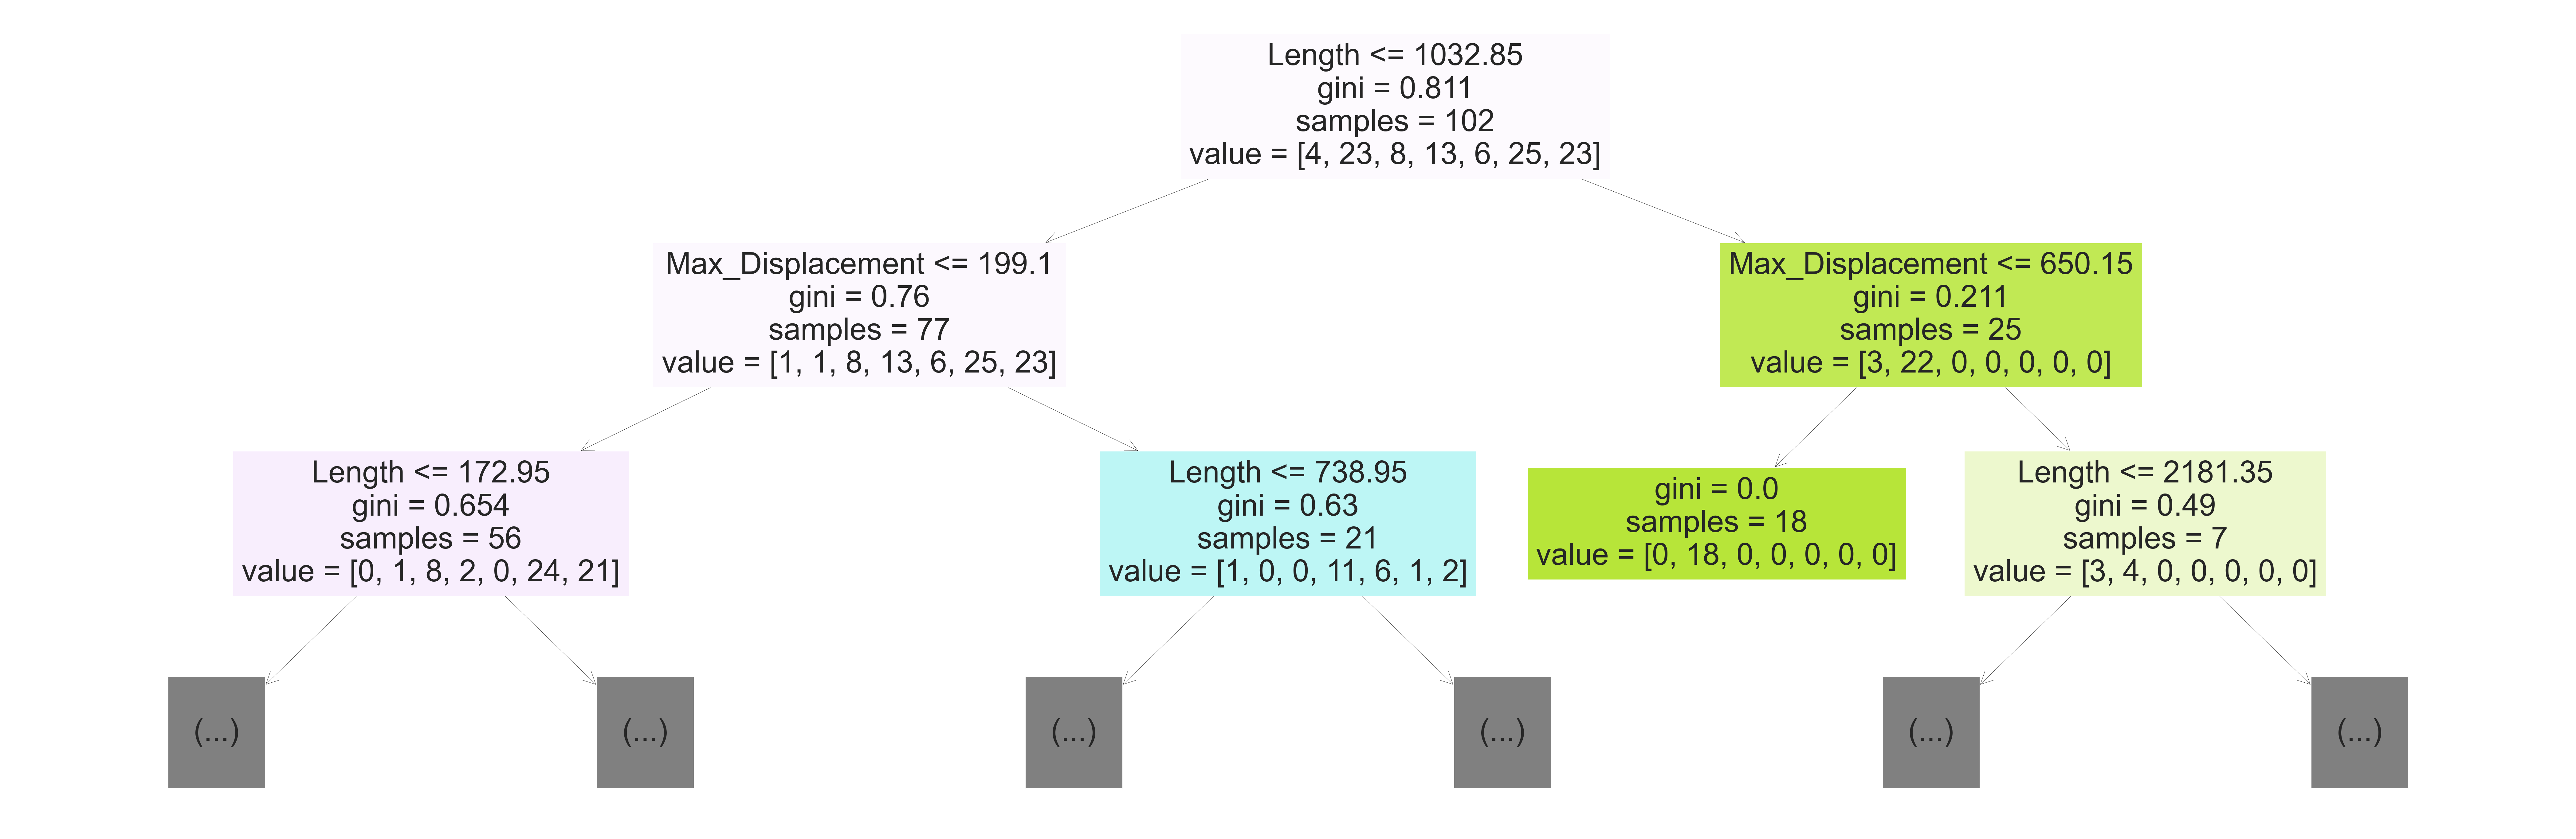

In [182]:
plt.figure(figsize=(150, 50))
plot_tree(tree_2, feature_names=X.columns, max_depth=2, filled=True);

# Support Vector Machine


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def tune_svm_model(X, y):
    # Define the hyperparameter search space for the SVM model
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
    
    # Create an SVM model instance
    model = SVC()
    
    print("Searching for the best hyperparameters for SVM...")
    
    # Create a GridSearchCV object for the SVM model
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2)
    
    # Perform hyperparameter tuning
    grid_search.fit(X, y)
    
    # Store the best hyperparameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print("Best hyperparameters for SVM:", best_params)
    print("Best score for SVM:", grid_search.best_score_)
    
    return best_params, best_model

# Example usage for SVM model
best_params_svm, best_model_svm = tune_svm_model(X_train, y_train)

# Print the best hyperparameters and use best_model_svm for further evaluation or testing
print("Best hyperparameters for SVM:", best_params_svm)


Searching for the best hyperparameters for SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters for SVM: {'C': 0.1, 'kernel': 'linear'}
Best score for SVM: 0.7057142857142857
Best hyperparameters for SVM: {'C': 0.1, 'kernel': 'linear'}


In [51]:
from sklearn import svm
clf = svm.SVC(C=10, kernel='rbf') # (kernel='rbf', max_iter = -1)
clf.fit(X_train, y_train) 

SVC(C=10)

In [52]:
yhatSVM = clf.predict(X_test)
yhatSVM[0:10]

array(['Triangle', 'Trapezoid', 'Triangle', 'Triangle', 'Trapezoid',
       'Trapezoid', 'Trapezoid', 'Positive Skewed', 'Triangle',
       'Positive Skewed'], dtype=object)

In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [54]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [55]:
print("SVM Classifier Precision: ", precision_score(y_test, yhatSVM, average='macro'))

SVM Classifier Precision:  0.4375


In [56]:
print("SVM Classifier F1 Score: ", f1_score(y_test, yhatSVM, average='macro'))

SVM Classifier F1 Score:  0.47619047619047616


In [57]:
print("SVM Classifier Recall Score: ", recall_score(y_test, yhatSVM, average='macro'))

SVM Classifier Recall Score:  0.5666666666666667


In [58]:
print("SVM Classifier Accuracy: ", accuracy_score(y_test, yhatSVM))

SVM Classifier Accuracy:  0.6


# Logistic Regression


In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

def tune_logistic_regression_model(X, y):

    # Define the hyperparameter search space for the Logistic Regression model
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2']
    }
    
    # Create a Logistic Regression model instance
    model = LogisticRegression()
    
    print("Searching for the best hyperparameters for Logistic Regression...")
    
    # Create a GridSearchCV object for the Logistic Regression model
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2)
    
    # Perform hyperparameter tuning
    grid_search.fit(X, y)
    
    # Store the best hyperparameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print("Best hyperparameters for Logistic Regression:", best_params)
    print("Best score for Logistic Regression:", grid_search.best_score_)
    
    return best_params, best_model

# Example usage for Logistic Regression model
best_params_logreg, best_model_logreg = tune_logistic_regression_model(X_train, y_train)

# Print the best hyperparameters and use best_model_logreg for further evaluation or testing
print("Best hyperparameters for Logistic Regression:", best_params_logreg)


Searching for the best hyperparameters for Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}
Best score for Logistic Regression: 0.6766666666666667
Best hyperparameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}


In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [61]:
logreg_model = LogisticRegression(C=10, penalty='l2')
logreg_model.fit(X_train, y_train)

LogisticRegression(C=10)

In [62]:
y_predLR = logreg_model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.60


# Random Forest Classifier

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def tune_random_forest_model(X, y):

    # Define the hyperparameter search space for the Random Forest model
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30]
    }
    
    # Create a Random Forest model instance
    model = RandomForestClassifier()
    
    print("Searching for the best hyperparameters for Random Forest...")
    
    # Create a GridSearchCV object for the Random Forest model
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2)
    
    # Perform hyperparameter tuning
    grid_search.fit(X, y)
    
    # Store the best hyperparameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print("Best hyperparameters for Random Forest:", best_params)
    print("Best score for Random Forest:", grid_search.best_score_)
    
    return best_params, best_model

# Example usage for Random Forest model
best_params_rf, best_model_rf = tune_random_forest_model(X_train, y_train)

# Print the best hyperparameters and use best_model_rf for further evaluation or testing
print("Best hyperparameters for Random Forest:", best_params_rf)


Searching for the best hyperparameters for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters for Random Forest: {'max_depth': 20, 'n_estimators': 100}
Best score for Random Forest: 0.6666666666666667
Best hyperparameters for Random Forest: {'max_depth': 20, 'n_estimators': 100}


In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
RanFor_model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=50,
                               max_depth=5
                                     )

In [66]:
RanFor_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, n_jobs=-1, random_state=42)

In [67]:
preds_RanFor = RanFor_model.predict(X_test)

In [68]:
print('Accuracy of Random Forest Classifier on train set: {:.2f}'.format(accuracy_score(y_test, preds_RanFor)))

Accuracy of Random Forest Classifier on train set: 0.80


## Summary of hyperparameter Search

In [69]:
models = {
            'KNN' : kNN_model,
            'KNN2' : kNN_model2,
            'Tree_1' : tree_1,
            'Tree_2' : tree_2,
            'SVM' : clf,
            'LogReg' : logreg_model,
            'RanFor' : RanFor_model
        }

In [70]:
from sklearn.model_selection import GridSearchCV

def tune_hyperparameters(models, param_grid, X, y):
    """
    Perform hyperparameter tuning for a dictionary of models using Grid Search.
    
    Parameters:
    - models (dict): A dictionary containing model names as keys and model instances as values.
    - param_grid (dict): A dictionary specifying the hyperparameter search space for each model.
    - X (array-like): The feature matrix.
    - y (array-like): The target labels.
    
    Returns:
    - best_params (dict): A dictionary containing the best hyperparameters found for each model.
    - best_models (dict): A dictionary containing the best model instances for each model.
    """
    best_params = {}
    best_models = {}
    
    for model_name, model in models.items():
        print(f"Searching for the best hyperparameters for {model_name}...")
        
        # Create a GridSearchCV object for the model
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, n_jobs=-1, verbose=2)
        
        # Perform hyperparameter tuning
        grid_search.fit(X, y)
        
        # Store the best hyperparameters and best model
        best_params[model_name] = grid_search.best_params_
        best_models[model_name] = grid_search.best_estimator_
        
        print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}\n")
    
    return best_params, best_models

# Define the hyperparameter search space for each model
param_grid = {
    'KNN': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'KNN2': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'Tree_1': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Tree_2': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'LogReg': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
    'RanFor': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
}

# Call the function to tune hyperparameters
best_params, best_models = tune_hyperparameters(models, param_grid, X_train, y_train)

# Now you have the best hyperparameters and best models for each model


Searching for the best hyperparameters for KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters for KNN: {'n_neighbors': 7, 'weights': 'distance'}
Best score for KNN: 0.6571428571428571

Searching for the best hyperparameters for KNN2...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters for KNN2: {'n_neighbors': 7, 'weights': 'distance'}
Best score for KNN2: 0.6571428571428571

Searching for the best hyperparameters for Tree_1...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters for Tree_1: {'max_depth': None, 'min_samples_split': 5}
Best score for Tree_1: 0.6466666666666667

Searching for the best hyperparameters for Tree_2...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters for Tree_2: {'max_depth': 20, 'min_samples_split': 5}
Best score for Tree_2: 0.6661904761904762

Searching for the best hyperparameters for SVM...
Fitting 5 folds for each of 6 candida

# Model Evaluation using Validation set

In [71]:
from sklearn.metrics import precision_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

In [72]:
test_y = y_test
print(test_y)

['Triangle' 'Trapezoid' 'Triangle' 'Trapezoid' 'Trapezoid' 'Trapezoid'
 'Triangle' 'Positive Skewed' 'Overlap' 'Trapezoid']


## Modelling

In [73]:
knn_yhat = kNN_model.predict(X_test)

print("KNN Precision Score: %.2f" % precision_score(y_test, knn_yhat, average='macro'))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_yhat, average='weighted'))
print("KNN Recall Score: %.2f" % recall_score(y_test, knn_yhat, average='macro'))
print("KNN Accuracy Score: %.2f" % accuracy_score(y_test, knn_yhat))
print("KNN Jaccard Score: %.2f" % jaccard_score(y_test, knn_yhat, average='macro'))

KNN Precision Score: 0.50
KNN F1-score: 0.62
KNN Recall Score: 0.57
KNN Accuracy Score: 0.60
KNN Jaccard Score: 0.36


In [74]:
tree_yhat = tree_1.predict(X_test)
tree_yhat

array(['Triangle', 'Trapezoid', 'Overlap', 'Positive Skewed', 'Trapezoid',
       'Trapezoid', 'Positive Skewed', 'Positive Skewed', 'Overlap',
       'Positive Skewed'], dtype=object)

In [75]:
print("Tree-1 Precision Score: %.2f" % precision_score(y_test, tree_yhat, average='macro'))
print("Tree-1 F1-score: %.2f" % f1_score(y_test, tree_yhat, average='weighted'))
print("Tree-1 Recall Score: %.2f" % recall_score(y_test, tree_yhat, average='macro'))
print("Tree-1 Accuracy Score: %.2f" % accuracy_score(y_test, tree_yhat))
print("Tree-1 Jaccard Score: %.2f" % jaccard_score(y_test, tree_yhat, average='macro'))

Tree-1 Precision Score: 0.69
Tree-1 F1-score: 0.63
Tree-1 Recall Score: 0.73
Tree-1 Accuracy Score: 0.60
Tree-1 Jaccard Score: 0.42


In [76]:
tree_yhat2 = tree_2.predict(X_test)

In [77]:
print("Tree-2 Precision Score: %.2f" % precision_score(y_test, tree_yhat2, average='macro'))
print("Tree-2 F1-score: %.2f" % f1_score(y_test, tree_yhat2, average='weighted'))
print("Tree-2 Recall Score: %.2f" % recall_score(y_test, tree_yhat2, average='macro'))
print("Tree-2 Accuracy Score: %.2f" % accuracy_score(y_test, tree_yhat2))
print("Tree-2 Jaccard Score: %.2f" % jaccard_score(y_test, tree_yhat2, average='macro'))

Tree-2 Precision Score: 0.49
Tree-2 F1-score: 0.67
Tree-2 Recall Score: 0.62
Tree-2 Accuracy Score: 0.70
Tree-2 Jaccard Score: 0.42


In [78]:
SVM_yhat = clf.predict(X_test)

In [79]:
print("SVM Precision Score: %.2f" % precision_score(y_test, SVM_yhat, average='macro'))
print("SVM F1-score: %.2f" % f1_score(y_test, SVM_yhat, average='weighted'))
print("SVM Recall Accuracy Score: %.2f" % recall_score(y_test, SVM_yhat, average='macro'))
print("SVM Accuracy Score: %.2f" % accuracy_score(y_test, SVM_yhat))
print("SVM Jaccard Score: %.2f" % jaccard_score(y_test, SVM_yhat, average='macro'))

SVM Precision Score: 0.44
SVM F1-score: 0.57
SVM Recall Accuracy Score: 0.57
SVM Accuracy Score: 0.60
SVM Jaccard Score: 0.35


In [80]:
logreg_yhat = logreg_model.predict(X_test)

In [81]:
print("LogisticRegression Precision Score: %.2f" % precision_score(y_test, logreg_yhat, average='macro'))
print("LogisticRegression F1-score: %.2f" % f1_score(y_test, logreg_yhat, average='weighted'))
print("LogisticRegression Recall Score: %.2f" % recall_score(y_test, logreg_yhat, average='macro'))
print("LogisticRegression Accuracy Score: %.2f" % accuracy_score(y_test, logreg_yhat))
print("LogisticRegression Jaccard Score: %.2f" % jaccard_score(y_test, logreg_yhat, average='macro'))

LogisticRegression Precision Score: 0.44
LogisticRegression F1-score: 0.57
LogisticRegression Recall Score: 0.57
LogisticRegression Accuracy Score: 0.60
LogisticRegression Jaccard Score: 0.35


In [82]:
RanFor_yhat = RanFor_model.predict(X_test)

In [83]:
print("RandomForest Precision Score: %.2f" % precision_score(y_test, RanFor_yhat, average='macro'))
print("RandomForest F1-score: %.2f" % f1_score(y_test, RanFor_yhat, average='weighted'))
print("RandomForest Recall Score: %.2f" % recall_score(y_test, RanFor_yhat, average='macro'))
print("RandomForest Accuracy Score: %.2f" % accuracy_score(y_test, RanFor_yhat))
print("RandomForest Jaccard Score: %.2f" % jaccard_score(y_test, RanFor_yhat, average='macro'))

RandomForest Precision Score: 0.82
RandomForest F1-score: 0.81
RandomForest Recall Score: 0.87
RandomForest Accuracy Score: 0.80
RandomForest Jaccard Score: 0.71


# Important Features from Tree model

In [84]:
from sklearn.tree import plot_tree, export_text

In [85]:
df.head(5)

,Length,Max_Displacement,ProfilePatterns
0,259.1,459.5,Positive Skewed
1,310.7,13.9,Trapezoid
2,25.7,42.4,Trapezoid
3,561.8,75.6,Overlap
4,275.0,462.0,Positive Skewed


In [86]:
model_text = export_text(tree_2, feature_names=list(df[['Length','Max_Displacement']].columns))
print(model_text[:3000])

|--- Length <= 1032.85
|   |--- Max_Displacement <= 199.10
|   |   |--- Length <= 172.95
|   |   |   |--- class: Triangle
|   |   |--- Length >  172.95
|   |   |   |--- class: Trapezoid
|   |--- Max_Displacement >  199.10
|   |   |--- Length <= 738.95
|   |   |   |--- class: Positive Skewed
|   |   |--- Length >  738.95
|   |   |   |--- class: Semi-Circle
|--- Length >  1032.85
|   |--- Max_Displacement <= 650.15
|   |   |--- class: Negative Skewed
|   |--- Max_Displacement >  650.15
|   |   |--- Length <= 2181.35
|   |   |   |--- class: Bell
|   |   |--- Length >  2181.35
|   |   |   |--- class: Negative Skewed



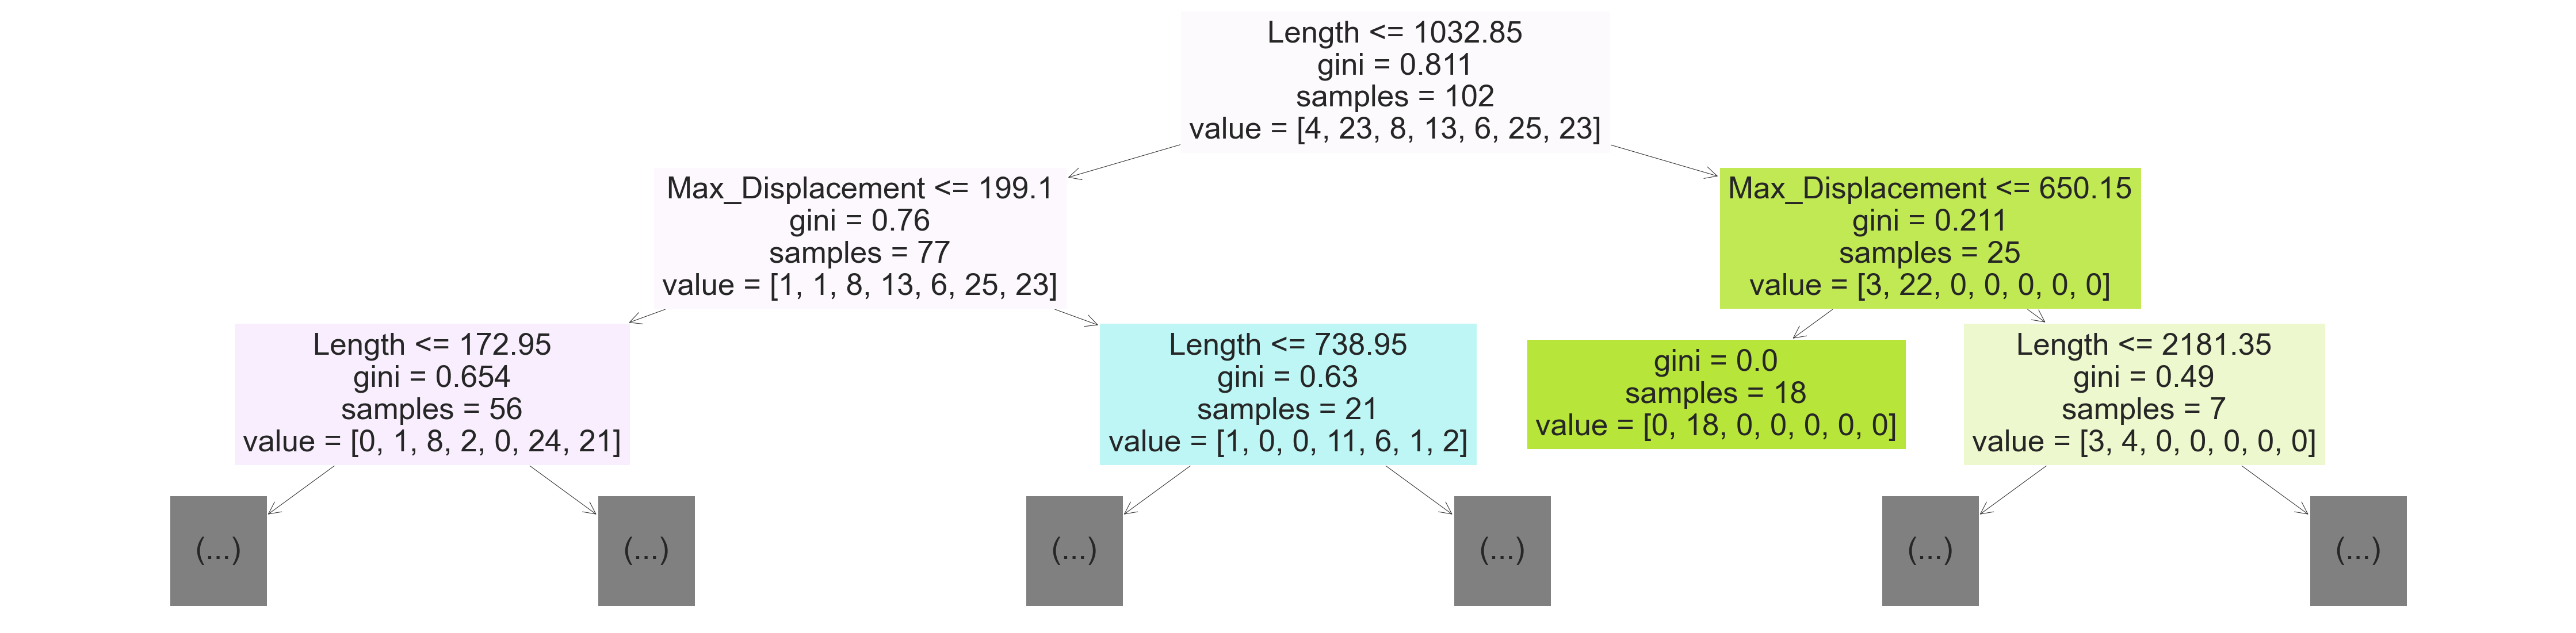

In [87]:
plt.figure(figsize=(80,20))
plot_tree(tree_2, feature_names=df[['Length','Max_Displacement']].columns, max_depth=2, filled=True);

In [88]:
importance_df = pd.DataFrame({
    'feature': df[['Length','Max_Displacement']].columns,
    'importance': tree_2.feature_importances_}).sort_values('importance', ascending=False)

In [89]:
importance_df

,feature,importance
0,Length,0.756958
1,Max_Displacement,0.243042


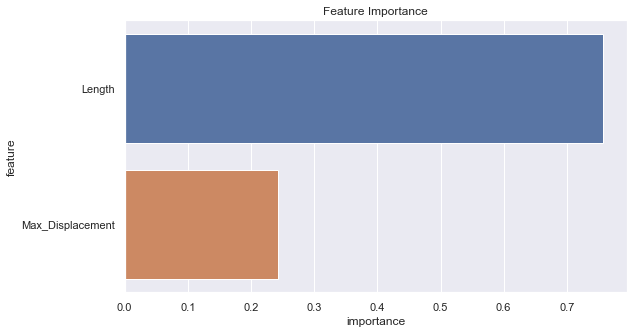

In [90]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Viewing Model Performance

## Results of the Validation set

In [153]:
len(X_test), len(y_test)

(10, 10)

In [154]:
# Models
models = {
            'KNN' : kNN_model,
            'KNN2' : kNN_model2,
            'Tree_1' : tree_1,
            'Tree_2' : tree_2,
            'SVM' : clf,
            'LogReg' : logreg_model,
            'RanFor' : RanFor_model
        }


# Create empty lists to store evaluation metrics
model_names_val = []
Precision_scores_val = []
F1_score_scores_val = []
Recall_scores_val = []
Accuracy_scores_val = []
Jaccard_scores_val = []
matthews_corrcoef_scores_val = []

# inputs_train, inputs_test, targets_train, targets_test

# Loop through the trained models and evaluate them
for model_name, model in models.items():
    # Make predictions on the unseen test data
    predictions = model.predict(X_test) # inputs_test, targets_test
    
    # Calculate Precision Score
    model_precision_score = precision_score(y_test, predictions, average='macro')
    
    # Calculate f1_score
    model_f1_score = f1_score(y_test, predictions, average='weighted')
    
    # Calculate recall_score
    model_recall_score = recall_score(y_test, predictions, average='macro')
    
    # Calculate accuracy_score
    model_accuracy_score = accuracy_score(y_test, predictions)  
    
    # Calculate jaccard_score
    model_jaccard_score = jaccard_score(y_test, predictions, average='macro')
    
    # Calculate matthews_corrcoef
    model_matthews_corrcoef= matthews_corrcoef(y_test, predictions)
    
    # Append the metrics to the lists
    model_names_val.append(model_name)
    Precision_scores_val.append(model_precision_score)
    F1_score_scores_val.append(model_f1_score)
    Recall_scores_val.append(model_recall_score)
    Accuracy_scores_val.append(model_accuracy_score)
    Jaccard_scores_val.append(model_jaccard_score)
    matthews_corrcoef_scores_val.append(model_matthews_corrcoef)

In [155]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame({
                            'Model': model_names_val,
                            'Accuracy_Score': Accuracy_scores_val,
                            'Precision_Score': Precision_scores_val,
                            'F1_Score': F1_score_scores_val,
                            'Recall_Score': Recall_scores_val,
                            'Jaccard_Score' : Jaccard_scores_val,
                            'Matthews_corrcoef_Score' : matthews_corrcoef_scores_val
                            })

In [156]:
metrics_df.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)

,Model,Accuracy_Score,Precision_Score,F1_Score,Recall_Score,Jaccard_Score,Matthews_corrcoef_Score
0,RanFor,0.8,0.825000,0.806667,0.866667,0.708333,0.707776
1,Tree_2,0.7,0.491667,0.666667,0.616667,0.416667,0.539751
2,KNN,0.6,0.500000,0.625000,0.566667,0.358333,0.471405
3,Tree_1,0.6,0.687500,0.631667,0.733333,0.420833,0.537853
4,SVM,0.6,0.437500,0.571429,0.566667,0.350000,0.406250
5,LogReg,0.6,0.437500,0.571429,0.566667,0.350000,0.406250
6,KNN2,0.5,0.500000,0.523810,0.516667,0.325000,0.353553


In [157]:
metrics_df.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True).to_csv(r'model_4_displacement-profiles-pattern_validation.csv')

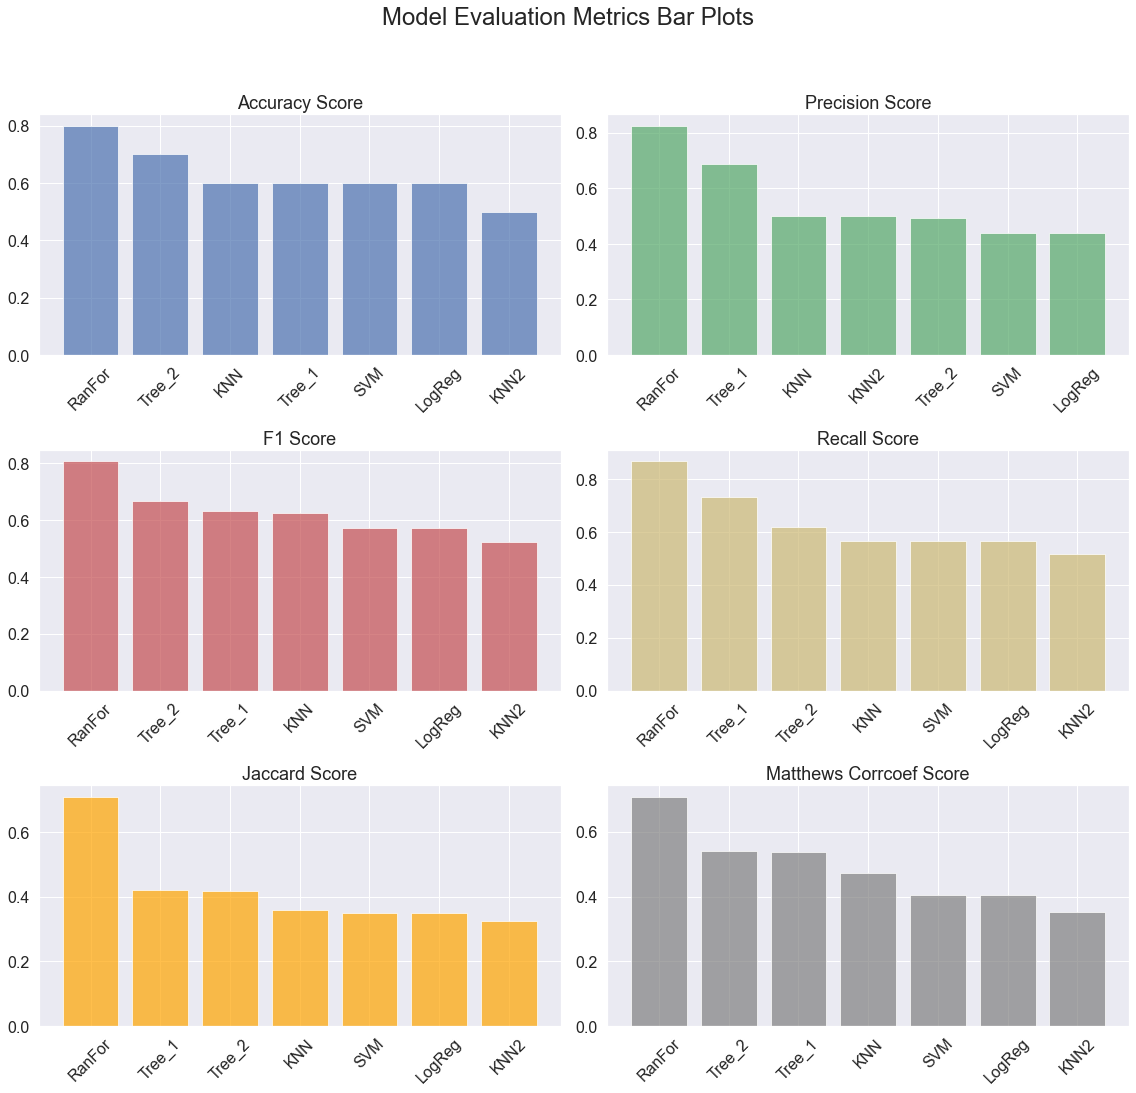

In [158]:
# Plot bar plots for each evaluation metric
font_size = 16
subtitle_size = 18
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.suptitle('Model Evaluation Metrics Bar Plots', fontsize=24)


# Plot Accuracy_Score bar plot
axes[0, 0].bar(metrics_df.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)['Accuracy_Score'], 
               color='b', alpha=0.7)
axes[0, 0].set_title('Accuracy Score', fontsize=subtitle_size)
axes[0, 0].tick_params(axis='both', labelsize=font_size)


# Plot Precision_Score bar plot
axes[0, 1].bar(metrics_df.sort_values(by='Precision_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='Precision_Score', ascending=False).reset_index(drop=True)['Precision_Score'], 
               color='g', alpha=0.7)
axes[0, 1].set_title('Precision Score', fontsize=subtitle_size)
axes[0, 1].tick_params(axis='both', labelsize=font_size)


# Plot F1_Score bar plot
axes[1, 0].bar(metrics_df.sort_values(by='F1_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='F1_Score', ascending=False).reset_index(drop=True)['F1_Score'], 
               color='r', alpha=0.7)
axes[1, 0].set_title('F1 Score', fontsize=subtitle_size)
axes[1, 0].tick_params(axis='both', labelsize=font_size)


# Plot Recall_Score bar plot
axes[1, 1].bar(metrics_df.sort_values(by='Recall_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='Recall_Score', ascending=False).reset_index(drop=True)['Recall_Score'], 
               color='y', alpha=0.7)
axes[1, 1].set_title('Recall Score', fontsize=subtitle_size)
axes[1, 1].tick_params(axis='both', labelsize=font_size)


# Plot Jaccard_Score bar plot
axes[2, 0].bar(metrics_df.sort_values(by='Jaccard_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='Jaccard_Score', ascending=False).reset_index(drop=True)['Jaccard_Score'], 
               color='orange', alpha=0.7)
axes[2, 0].set_title('Jaccard Score', fontsize=subtitle_size)
axes[2, 0].tick_params(axis='both', labelsize=font_size)


# Plot Jaccard_Score bar plot
axes[2, 1].bar(metrics_df.sort_values(by='Matthews_corrcoef_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='Matthews_corrcoef_Score', ascending=False).reset_index(drop=True)['Matthews_corrcoef_Score'], 
               color='gray', alpha=0.7)
axes[2, 1].set_title('Matthews Corrcoef Score', fontsize=subtitle_size)
axes[2, 1].tick_params(axis='both', labelsize=font_size)


# Rotate x-axis labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()

## confusion_matrix and report using the Best Model - Decision tree 

### Validation set

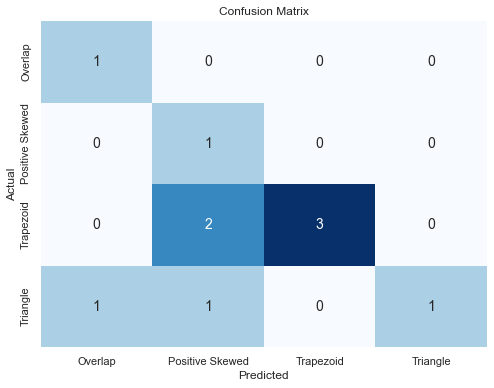

Classification Report:
                  precision    recall  f1-score   support

        Overlap       0.50      1.00      0.67         1
Positive Skewed       0.25      1.00      0.40         1
      Trapezoid       1.00      0.60      0.75         5
       Triangle       1.00      0.33      0.50         3

       accuracy                           0.60        10
      macro avg       0.69      0.73      0.58        10
   weighted avg       0.88      0.60      0.63        10



In [159]:
# Get unique class labels from the actual and predicted data
unique_labels = np.unique(np.concatenate((y_test, tree_1.predict(X_test))))

# Create a confusion matrix
cm = confusion_matrix(y_test, tree_1.predict(X_test), labels=unique_labels)

# Create a DataFrame for better visualization
confusion_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_test, tree_1.predict(X_test), target_names=unique_labels)
print("Classification Report:\n", report)


## Results of the Testing set

In [160]:
len(inputs_unseen_test), len(targets_unseen_test)

(10, 10)

In [161]:
# Models
models = {
            'KNN' : kNN_model,
            'KNN2' : kNN_model2,
            'Tree_1' : tree_1,
            'Tree_2' : tree_2,
            'SVM' : clf,
            'LogReg' : logreg_model,
            'RanFor' : RanFor_model
        }


# Create empty lists to store evaluation metrics
model_names_val = []
Precision_scores_val = []
F1_score_scores_val = []
Recall_scores_val = []
Accuracy_scores_val = []
Jaccard_scores_val = []
matthews_corrcoef_scores_val = []

# inputs_train, inputs_test, targets_train, targets_test

# Loop through the trained models and evaluate them
for model_name, model in models.items():
    # Make predictions on the unseen test data
    predictions = model.predict(inputs_unseen_test) 

    # Calculate Precision Score
    model_precision_score = precision_score(targets_unseen_test, predictions, average='macro')
    
    # Calculate f1_score
    model_f1_score = f1_score(targets_unseen_test, predictions, average='weighted')
    
    # Calculate recall_score
    model_recall_score = recall_score(targets_unseen_test, predictions, average='macro')
    
    # Calculate accuracy_score
    model_accuracy_score = accuracy_score(targets_unseen_test, predictions)
    
    # Calculate jaccard_score
    model_jaccard_score = jaccard_score(targets_unseen_test, predictions, average='macro')
    
    # Calculate matthews_corrcoef
    model_matthews_corrcoef= matthews_corrcoef(targets_unseen_test, predictions)
    
    # Append the metrics to the lists
    model_names_val.append(model_name)
    Precision_scores_val.append(model_precision_score)
    F1_score_scores_val.append(model_f1_score)
    Recall_scores_val.append(model_recall_score)
    Accuracy_scores_val.append(model_accuracy_score)
    Jaccard_scores_val.append(model_jaccard_score)
    matthews_corrcoef_scores_val.append(model_matthews_corrcoef)

In [162]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame({
                            'Model': model_names_val,
                            'Accuracy_Score': Accuracy_scores_val,
                            'Precision_Score': Precision_scores_val,
                            'F1_Score': F1_score_scores_val,
                            'Recall_Score': Recall_scores_val,
                            'Jaccard_Score' : Jaccard_scores_val,
                            'Matthews_corrcoef_Score' : matthews_corrcoef_scores_val
                            })

In [163]:
metrics_df.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)

,Model,Accuracy_Score,Precision_Score,F1_Score,Recall_Score,Jaccard_Score,Matthews_corrcoef_Score
0,RanFor,0.8,0.700000,0.776190,0.750000,0.650000,0.764184
1,Tree_1,0.6,0.500000,0.593333,0.464286,0.392857,0.573384
2,SVM,0.5,0.516667,0.476667,0.550000,0.356667,0.430722
3,KNN,0.4,0.388889,0.406667,0.375000,0.222222,0.298928
4,KNN2,0.4,0.404762,0.440000,0.321429,0.261905,0.308098
5,Tree_2,0.4,0.516667,0.410000,0.450000,0.256667,0.301398
6,LogReg,0.3,0.291667,0.293333,0.291667,0.158333,0.173349


In [164]:
metrics_df.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True).to_csv(r'model_4_displacement-profiles-pattern_test.csv')

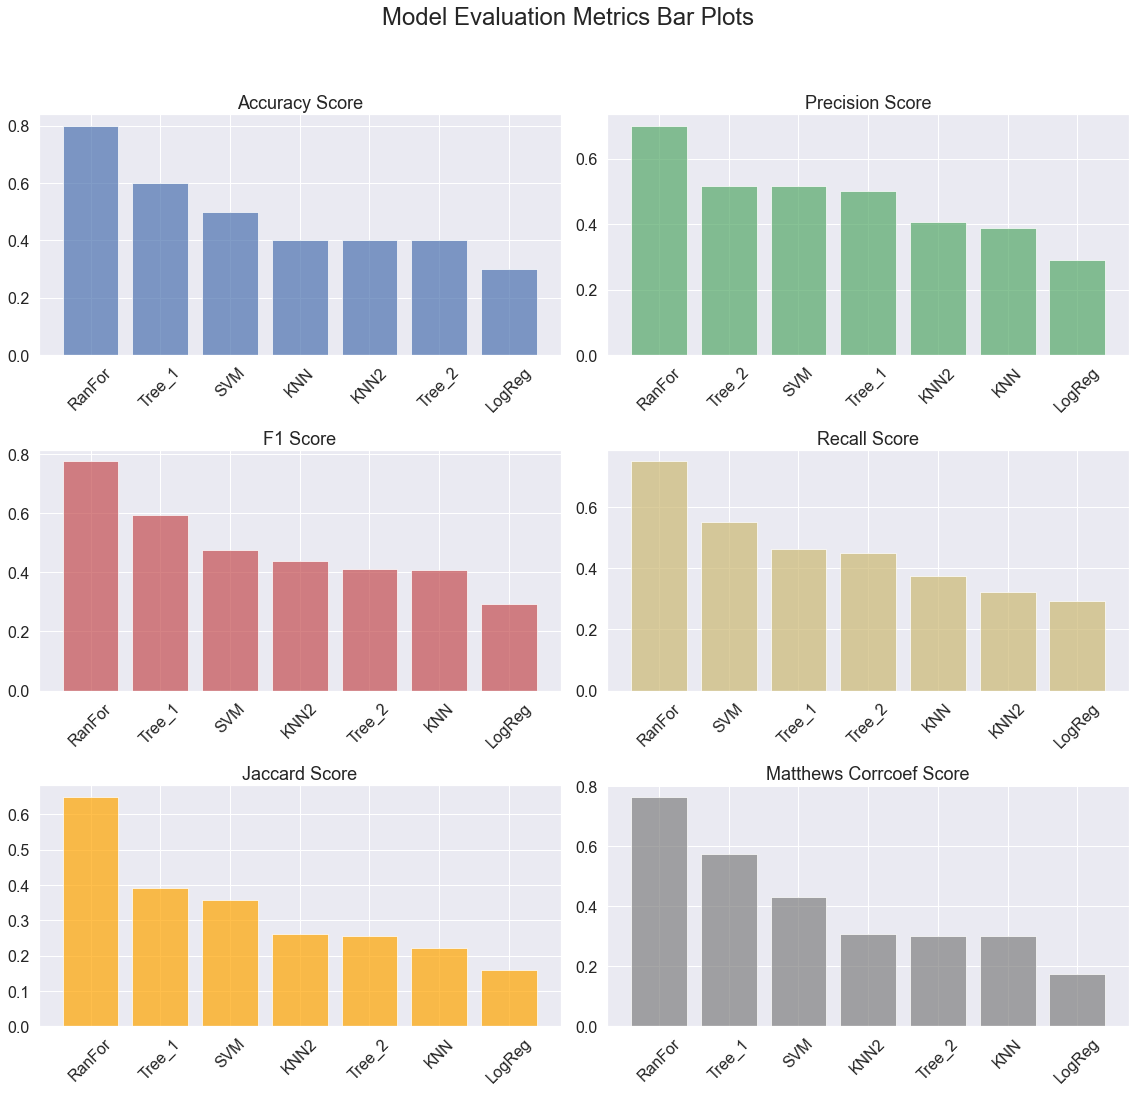

In [165]:
# Plot bar plots for each evaluation metric
font_size = 16
subtitle_size = 18
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.suptitle('Model Evaluation Metrics Bar Plots', fontsize=24)


# Plot Accuracy_Score bar plot
axes[0, 0].bar(metrics_df.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)['Accuracy_Score'], 
               color='b', alpha=0.7)
axes[0, 0].set_title('Accuracy Score', fontsize=subtitle_size)
axes[0, 0].tick_params(axis='both', labelsize=font_size)


# Plot Precision_Score bar plot
axes[0, 1].bar(metrics_df.sort_values(by='Precision_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='Precision_Score', ascending=False).reset_index(drop=True)['Precision_Score'], 
               color='g', alpha=0.7)
axes[0, 1].set_title('Precision Score', fontsize=subtitle_size)
axes[0, 1].tick_params(axis='both', labelsize=font_size)


# Plot F1_Score bar plot
axes[1, 0].bar(metrics_df.sort_values(by='F1_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='F1_Score', ascending=False).reset_index(drop=True)['F1_Score'], 
               color='r', alpha=0.7)
axes[1, 0].set_title('F1 Score', fontsize=subtitle_size)
axes[1, 0].tick_params(axis='both', labelsize=font_size)


# Plot Recall_Score bar plot
axes[1, 1].bar(metrics_df.sort_values(by='Recall_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='Recall_Score', ascending=False).reset_index(drop=True)['Recall_Score'], 
               color='y', alpha=0.7)
axes[1, 1].set_title('Recall Score', fontsize=subtitle_size)
axes[1, 1].tick_params(axis='both', labelsize=font_size)


# Plot Jaccard_Score bar plot
axes[2, 0].bar(metrics_df.sort_values(by='Jaccard_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='Jaccard_Score', ascending=False).reset_index(drop=True)['Jaccard_Score'], 
               color='orange', alpha=0.7)
axes[2, 0].set_title('Jaccard Score', fontsize=subtitle_size)
axes[2, 0].tick_params(axis='both', labelsize=font_size)


# Plot Jaccard_Score bar plot
axes[2, 1].bar(metrics_df.sort_values(by='Matthews_corrcoef_Score', ascending=False).reset_index(drop=True)['Model'], 
               metrics_df.sort_values(by='Matthews_corrcoef_Score', ascending=False).reset_index(drop=True)['Matthews_corrcoef_Score'], 
               color='gray', alpha=0.7)
axes[2, 1].set_title('Matthews Corrcoef Score', fontsize=subtitle_size)
axes[2, 1].tick_params(axis='both', labelsize=font_size)


# Rotate x-axis labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()

## Confusion Matrix and Report using the Best Model - Decision tree 

### Testing set

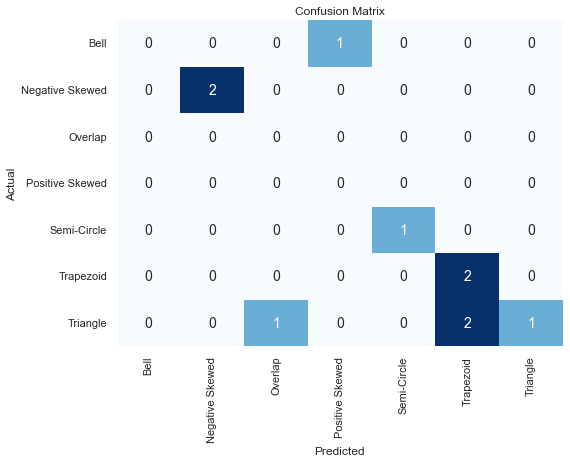

Classification Report:
                  precision    recall  f1-score   support

           Bell       0.00      0.00      0.00         1
Negative Skewed       1.00      1.00      1.00         2
        Overlap       0.00      0.00      0.00         0
Positive Skewed       0.00      0.00      0.00         0
    Semi-Circle       1.00      1.00      1.00         1
      Trapezoid       0.50      1.00      0.67         2
       Triangle       1.00      0.25      0.40         4

       accuracy                           0.60        10
      macro avg       0.50      0.46      0.44        10
   weighted avg       0.80      0.60      0.59        10



In [102]:
# Get unique class labels from the actual and predicted data
unique_labels = np.unique(np.concatenate((targets_unseen_test, tree_1.predict(inputs_unseen_test))))

# Create a confusion matrix
cm = confusion_matrix(targets_unseen_test, tree_1.predict(inputs_unseen_test), labels=unique_labels)

# Create a DataFrame for better visualization
confusion_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(targets_unseen_test, tree_1.predict(inputs_unseen_test), target_names=unique_labels)
print("Classification Report:\n", report)


## Confusion Matrix and Classification Report

## Training set

Confusion Matrix for KNN:



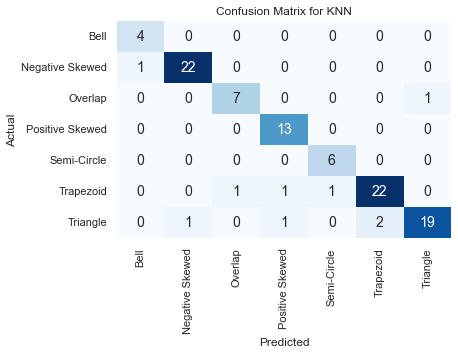

Classification Report for KNN:
                 precision    recall  f1-score     support
Bell              0.800000  1.000000  0.888889    4.000000
Negative Skewed   0.956522  0.956522  0.956522   23.000000
Overlap           0.875000  0.875000  0.875000    8.000000
Positive Skewed   0.866667  1.000000  0.928571   13.000000
Semi-Circle       0.857143  1.000000  0.923077    6.000000
Trapezoid         0.916667  0.880000  0.897959   25.000000
Triangle          0.950000  0.826087  0.883721   23.000000
accuracy          0.911765  0.911765  0.911765    0.911765
macro avg         0.888857  0.933944  0.907677  102.000000
weighted avg      0.915453  0.911765  0.911177  102.000000

Confusion Matrix for KNN2:



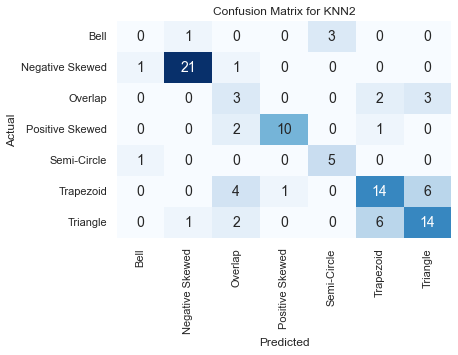

Classification Report for KNN2:
                 precision    recall  f1-score     support
Bell              0.000000  0.000000  0.000000    4.000000
Negative Skewed   0.913043  0.913043  0.913043   23.000000
Overlap           0.250000  0.375000  0.300000    8.000000
Positive Skewed   0.909091  0.769231  0.833333   13.000000
Semi-Circle       0.625000  0.833333  0.714286    6.000000
Trapezoid         0.608696  0.560000  0.583333   25.000000
Triangle          0.608696  0.608696  0.608696   23.000000
accuracy          0.656863  0.656863  0.656863    0.656863
macro avg         0.559218  0.579900  0.564670  102.000000
weighted avg      0.664564  0.656863  0.657866  102.000000

Confusion Matrix for Tree_1:



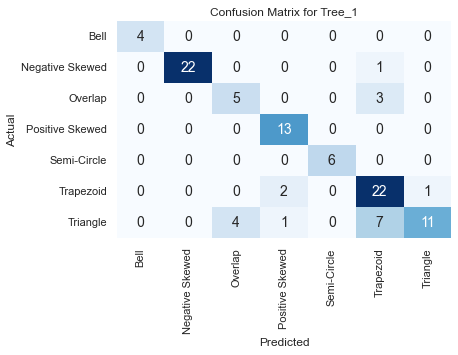

Classification Report for Tree_1:
                 precision    recall  f1-score     support
Bell              1.000000  1.000000  1.000000    4.000000
Negative Skewed   1.000000  0.956522  0.977778   23.000000
Overlap           0.555556  0.625000  0.588235    8.000000
Positive Skewed   0.812500  1.000000  0.896552   13.000000
Semi-Circle       1.000000  1.000000  1.000000    6.000000
Trapezoid         0.666667  0.880000  0.758621   25.000000
Triangle          0.916667  0.478261  0.628571   23.000000
accuracy          0.813725  0.813725  0.813725    0.813725
macro avg         0.850198  0.848540  0.835680  102.000000
weighted avg      0.840754  0.813725  0.806594  102.000000

Confusion Matrix for Tree_2:



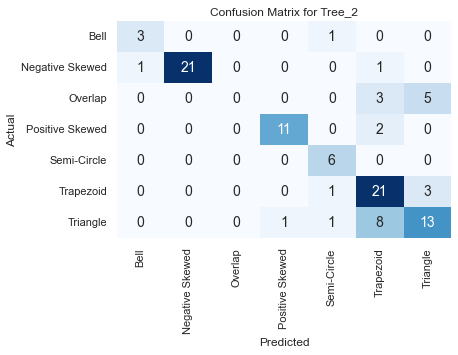

Classification Report for Tree_2:
                 precision    recall  f1-score     support
Bell              0.750000  0.750000  0.750000    4.000000
Negative Skewed   1.000000  0.913043  0.954545   23.000000
Overlap           0.000000  0.000000  0.000000    8.000000
Positive Skewed   0.916667  0.846154  0.880000   13.000000
Semi-Circle       0.666667  1.000000  0.800000    6.000000
Trapezoid         0.600000  0.840000  0.700000   25.000000
Triangle          0.619048  0.565217  0.590909   23.000000
accuracy          0.735294  0.735294  0.735294    0.735294
macro avg         0.650340  0.702059  0.667922  102.000000
weighted avg      0.697596  0.735294  0.708681  102.000000

Confusion Matrix for SVM:



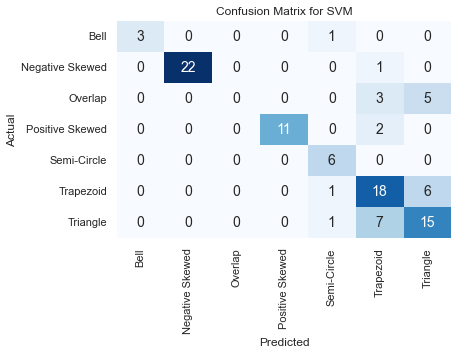

Classification Report for SVM:
                 precision    recall  f1-score     support
Bell              1.000000  0.750000  0.857143    4.000000
Negative Skewed   1.000000  0.956522  0.977778   23.000000
Overlap           0.000000  0.000000  0.000000    8.000000
Positive Skewed   1.000000  0.846154  0.916667   13.000000
Semi-Circle       0.666667  1.000000  0.800000    6.000000
Trapezoid         0.580645  0.720000  0.642857   25.000000
Triangle          0.576923  0.652174  0.612245   23.000000
accuracy          0.735294  0.735294  0.735294    0.735294
macro avg         0.689176  0.703550  0.686670  102.000000
weighted avg      0.703778  0.735294  0.713600  102.000000

Confusion Matrix for LogReg:



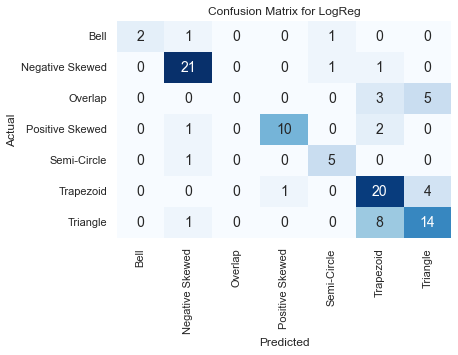

Classification Report for LogReg:
                 precision    recall  f1-score     support
Bell              1.000000  0.500000  0.666667    4.000000
Negative Skewed   0.840000  0.913043  0.875000   23.000000
Overlap           0.000000  0.000000  0.000000    8.000000
Positive Skewed   0.909091  0.769231  0.833333   13.000000
Semi-Circle       0.714286  0.833333  0.769231    6.000000
Trapezoid         0.588235  0.800000  0.677966   25.000000
Triangle          0.608696  0.608696  0.608696   23.000000
accuracy          0.705882  0.705882  0.705882    0.705882
macro avg         0.665758  0.632043  0.632985  102.000000
weighted avg      0.667939  0.705882  0.678329  102.000000

Confusion Matrix for RanFor:



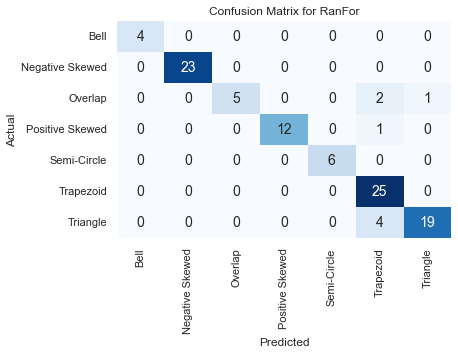

Classification Report for RanFor:
                 precision    recall  f1-score     support
Bell              1.000000  1.000000  1.000000    4.000000
Negative Skewed   1.000000  1.000000  1.000000   23.000000
Overlap           1.000000  0.625000  0.769231    8.000000
Positive Skewed   1.000000  0.923077  0.960000   13.000000
Semi-Circle       1.000000  1.000000  1.000000    6.000000
Trapezoid         0.781250  1.000000  0.877193   25.000000
Triangle          0.950000  0.826087  0.883721   23.000000
accuracy          0.921569  0.921569  0.921569    0.921569
macro avg         0.961607  0.910595  0.927164  102.000000
weighted avg      0.935110  0.921569  0.920483  102.000000



In [103]:
# Define your models
models = {
    'KNN': kNN_model,
    'KNN2': kNN_model2,
    'Tree_1': tree_1,
    'Tree_2': tree_2,
    'SVM': clf,
    'LogReg': logreg_model,
    'RanFor': RanFor_model
}

# Assuming you have a dataset and true labels (actual)
# data and actual should be replaced with your dataset and true labels
data = X_train     
actual = y_train

# Initialize an empty dictionary to store confusion matrices
confusion_matrices = {}

# Initialize an empty dictionary to store classification reports
classification_reports = {}

# Iterate through each model and evaluate it
for model_name, model in models.items():
    # Make predictions using the current model
    predicted = model.predict(data)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(actual, predicted)
    
    # Store the confusion matrix in the dictionary
    confusion_matrices[model_name] = cm
    
    # Generate the classification report
    report = classification_report(actual, predicted, output_dict=True)
    
    # Store the classification report in the dictionary
    classification_reports[model_name] = report

# Display confusion matrices and classification reports
for model_name, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {model_name}:\n")
    
    # Create a DataFrame for better visualization
    confusion_df = pd.DataFrame(cm, index=np.unique(actual), columns=np.unique(actual))
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Display the classification report
    report = classification_reports[model_name]
    df = pd.DataFrame(report).transpose()
    print(f"Classification Report for {model_name}:\n{df}\n")


## Validation Set

Confusion Matrix for KNN:



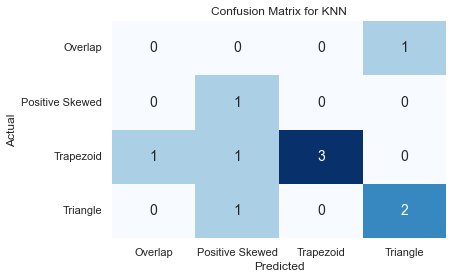

Classification Report for KNN:
                 precision    recall  f1-score  support
Overlap           0.000000  0.000000  0.000000      1.0
Positive Skewed   0.333333  1.000000  0.500000      1.0
Trapezoid         1.000000  0.600000  0.750000      5.0
Triangle          0.666667  0.666667  0.666667      3.0
accuracy          0.600000  0.600000  0.600000      0.6
macro avg         0.500000  0.566667  0.479167     10.0
weighted avg      0.733333  0.600000  0.625000     10.0

Confusion Matrix for KNN2:



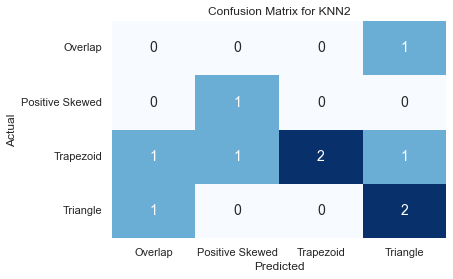

Classification Report for KNN2:
                 precision    recall  f1-score  support
Overlap                0.0  0.000000  0.000000      1.0
Positive Skewed        0.5  1.000000  0.666667      1.0
Trapezoid              1.0  0.400000  0.571429      5.0
Triangle               0.5  0.666667  0.571429      3.0
accuracy               0.5  0.500000  0.500000      0.5
macro avg              0.5  0.516667  0.452381     10.0
weighted avg           0.7  0.500000  0.523810     10.0

Confusion Matrix for Tree_1:



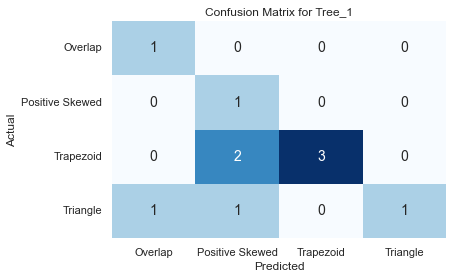

Classification Report for Tree_1:
                 precision    recall  f1-score  support
Overlap             0.5000  1.000000  0.666667      1.0
Positive Skewed     0.2500  1.000000  0.400000      1.0
Trapezoid           1.0000  0.600000  0.750000      5.0
Triangle            1.0000  0.333333  0.500000      3.0
accuracy            0.6000  0.600000  0.600000      0.6
macro avg           0.6875  0.733333  0.579167     10.0
weighted avg        0.8750  0.600000  0.631667     10.0

Confusion Matrix for Tree_2:



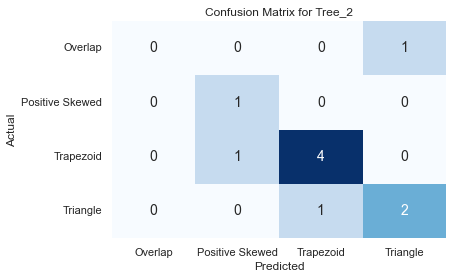

Classification Report for Tree_2:
                 precision    recall  f1-score  support
Overlap           0.000000  0.000000  0.000000      1.0
Positive Skewed   0.500000  1.000000  0.666667      1.0
Trapezoid         0.800000  0.800000  0.800000      5.0
Triangle          0.666667  0.666667  0.666667      3.0
accuracy          0.700000  0.700000  0.700000      0.7
macro avg         0.491667  0.616667  0.533333     10.0
weighted avg      0.650000  0.700000  0.666667     10.0

Confusion Matrix for SVM:



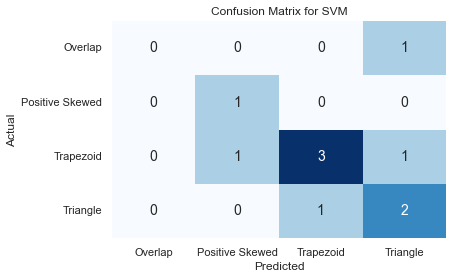

Classification Report for SVM:
                 precision    recall  f1-score  support
Overlap             0.0000  0.000000  0.000000      1.0
Positive Skewed     0.5000  1.000000  0.666667      1.0
Trapezoid           0.7500  0.600000  0.666667      5.0
Triangle            0.5000  0.666667  0.571429      3.0
accuracy            0.6000  0.600000  0.600000      0.6
macro avg           0.4375  0.566667  0.476190     10.0
weighted avg        0.5750  0.600000  0.571429     10.0

Confusion Matrix for LogReg:



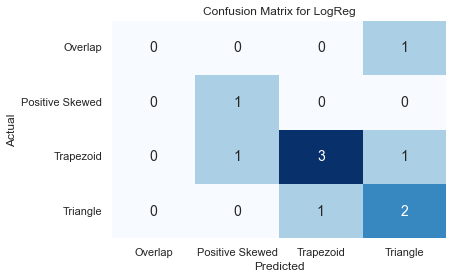

Classification Report for LogReg:
                 precision    recall  f1-score  support
Overlap             0.0000  0.000000  0.000000      1.0
Positive Skewed     0.5000  1.000000  0.666667      1.0
Trapezoid           0.7500  0.600000  0.666667      5.0
Triangle            0.5000  0.666667  0.571429      3.0
accuracy            0.6000  0.600000  0.600000      0.6
macro avg           0.4375  0.566667  0.476190     10.0
weighted avg        0.5750  0.600000  0.571429     10.0

Confusion Matrix for RanFor:



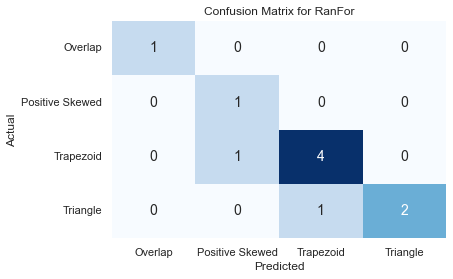

Classification Report for RanFor:
                 precision    recall  f1-score  support
Overlap              1.000  1.000000  1.000000      1.0
Positive Skewed      0.500  1.000000  0.666667      1.0
Trapezoid            0.800  0.800000  0.800000      5.0
Triangle             1.000  0.666667  0.800000      3.0
accuracy             0.800  0.800000  0.800000      0.8
macro avg            0.825  0.866667  0.816667     10.0
weighted avg         0.850  0.800000  0.806667     10.0



In [104]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define your models
models = {
    'KNN': kNN_model,
    'KNN2': kNN_model2,
    'Tree_1': tree_1,
    'Tree_2': tree_2,
    'SVM': clf,
    'LogReg': logreg_model,
    'RanFor': RanFor_model
}

# Assuming you have a dataset and true labels (actual)
# data and actual should be replaced with your dataset and true labels
data = X_test
actual = y_test

# Get the unique class labels from the actual data
unique_labels = np.unique(actual)

# Initialize an empty dictionary to store confusion matrices
confusion_matrices = {}

# Initialize an empty dictionary to store classification reports
classification_reports = {}

# Iterate through each model and evaluate it
for model_name, model in models.items():
    # Make predictions using the current model
    predicted = model.predict(data)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(actual, predicted, labels=unique_labels)
    
    # Store the confusion matrix in the dictionary
    confusion_matrices[model_name] = cm
    
    # Generate the classification report with target_names set to unique_labels
    report = classification_report(actual, predicted, labels=unique_labels, target_names=unique_labels, output_dict=True)
    
    # Store the classification report in the dictionary
    classification_reports[model_name] = report

# Display confusion matrices and classification reports
for model_name, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {model_name}:\n")
    
    # Create a DataFrame for better visualization
    confusion_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Display the classification report
    report = classification_reports[model_name]
    df = pd.DataFrame(report).transpose()
    print(f"Classification Report for {model_name}:\n{df}\n")


## Testing Set

Confusion Matrix for KNN:



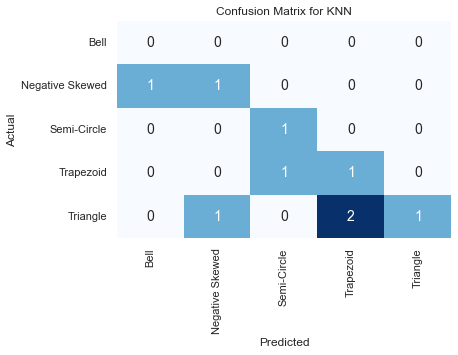

Classification Report for KNN:
                 precision  recall  f1-score  support
Bell              0.000000    0.00  0.000000      1.0
Negative Skewed   0.500000    0.50  0.500000      2.0
Semi-Circle       0.500000    1.00  0.666667      1.0
Trapezoid         0.333333    0.50  0.400000      2.0
Triangle          1.000000    0.25  0.400000      4.0
micro avg         0.444444    0.40  0.421053     10.0
macro avg         0.466667    0.45  0.393333     10.0
weighted avg      0.616667    0.40  0.406667     10.0

Confusion Matrix for KNN2:



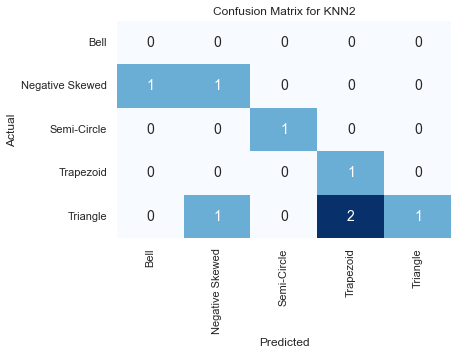

Classification Report for KNN2:
                 precision  recall  f1-score  support
Bell              0.000000    0.00  0.000000      1.0
Negative Skewed   0.500000    0.50  0.500000      2.0
Semi-Circle       1.000000    1.00  1.000000      1.0
Trapezoid         0.333333    0.50  0.400000      2.0
Triangle          1.000000    0.25  0.400000      4.0
micro avg         0.500000    0.40  0.444444     10.0
macro avg         0.566667    0.45  0.460000     10.0
weighted avg      0.666667    0.40  0.440000     10.0

Confusion Matrix for Tree_1:



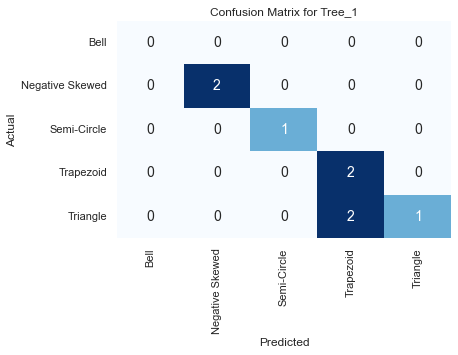

Classification Report for Tree_1:
                 precision  recall  f1-score  support
Bell                  0.00    0.00  0.000000      1.0
Negative Skewed       1.00    1.00  1.000000      2.0
Semi-Circle           1.00    1.00  1.000000      1.0
Trapezoid             0.50    1.00  0.666667      2.0
Triangle              1.00    0.25  0.400000      4.0
micro avg             0.75    0.60  0.666667     10.0
macro avg             0.70    0.65  0.613333     10.0
weighted avg          0.80    0.60  0.593333     10.0

Confusion Matrix for Tree_2:



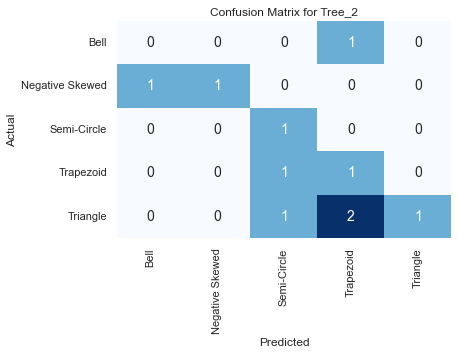

Classification Report for Tree_2:
                 precision  recall  f1-score  support
Bell              0.000000    0.00  0.000000      1.0
Negative Skewed   1.000000    0.50  0.666667      2.0
Semi-Circle       0.333333    1.00  0.500000      1.0
Trapezoid         0.250000    0.50  0.333333      2.0
Triangle          1.000000    0.25  0.400000      4.0
accuracy          0.400000    0.40  0.400000      0.4
macro avg         0.516667    0.45  0.380000     10.0
weighted avg      0.683333    0.40  0.410000     10.0

Confusion Matrix for SVM:



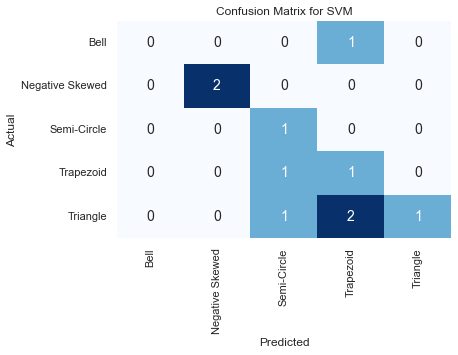

Classification Report for SVM:
                 precision  recall  f1-score  support
Bell              0.000000    0.00  0.000000      1.0
Negative Skewed   1.000000    1.00  1.000000      2.0
Semi-Circle       0.333333    1.00  0.500000      1.0
Trapezoid         0.250000    0.50  0.333333      2.0
Triangle          1.000000    0.25  0.400000      4.0
accuracy          0.500000    0.50  0.500000      0.5
macro avg         0.516667    0.55  0.446667     10.0
weighted avg      0.683333    0.50  0.476667     10.0

Confusion Matrix for LogReg:



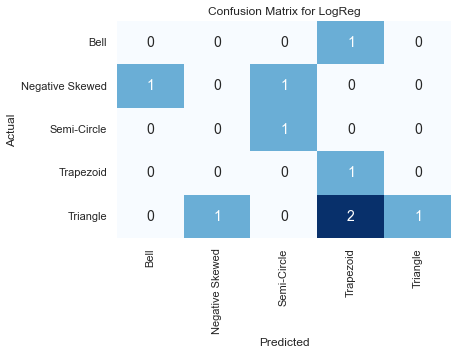

Classification Report for LogReg:
                 precision  recall  f1-score  support
Bell              0.000000    0.00  0.000000      1.0
Negative Skewed   0.000000    0.00  0.000000      2.0
Semi-Circle       0.500000    1.00  0.666667      1.0
Trapezoid         0.250000    0.50  0.333333      2.0
Triangle          1.000000    0.25  0.400000      4.0
micro avg         0.333333    0.30  0.315789     10.0
macro avg         0.350000    0.35  0.280000     10.0
weighted avg      0.500000    0.30  0.293333     10.0

Confusion Matrix for RanFor:



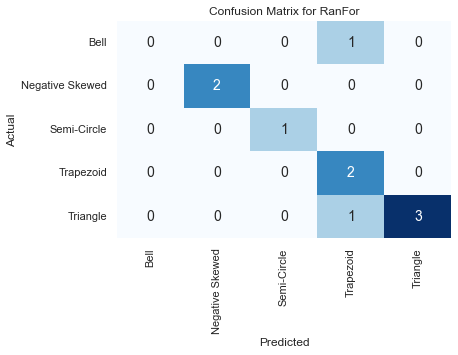

Classification Report for RanFor:
                 precision  recall  f1-score  support
Bell                   0.0    0.00  0.000000      1.0
Negative Skewed        1.0    1.00  1.000000      2.0
Semi-Circle            1.0    1.00  1.000000      1.0
Trapezoid              0.5    1.00  0.666667      2.0
Triangle               1.0    0.75  0.857143      4.0
accuracy               0.8    0.80  0.800000      0.8
macro avg              0.7    0.75  0.704762     10.0
weighted avg           0.8    0.80  0.776190     10.0



In [105]:
# Define your models
models = {
    'KNN': kNN_model,
    'KNN2': kNN_model2,
    'Tree_1': tree_1,
    'Tree_2': tree_2,
    'SVM': clf,
    'LogReg': logreg_model,
    'RanFor': RanFor_model
}

# Assuming you have a dataset and true labels (actual)
# data and actual should be replaced with your dataset and true labels
data = inputs_unseen_test
actual = targets_unseen_test

# Get the unique class labels from the actual data
unique_labels = np.unique(actual)

# Initialize an empty dictionary to store confusion matrices
confusion_matrices = {}

# Initialize an empty dictionary to store classification reports
classification_reports = {}

# Iterate through each model and evaluate it
for model_name, model in models.items():
    # Make predictions using the current model
    predicted = model.predict(data)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(actual, predicted, labels=unique_labels)
    
    # Store the confusion matrix in the dictionary
    confusion_matrices[model_name] = cm
    
    # Generate the classification report with target_names set to unique_labels
    report = classification_report(actual, predicted, labels=unique_labels, target_names=unique_labels, output_dict=True)
    
    # Store the classification report in the dictionary
    classification_reports[model_name] = report

# Display confusion matrices and classification reports
for model_name, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {model_name}:\n")
    
    # Create a DataFrame for better visualization
    confusion_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Display the classification report
    report = classification_reports[model_name]
    df = pd.DataFrame(report).transpose()
    print(f"Classification Report for {model_name}:\n{df}\n")


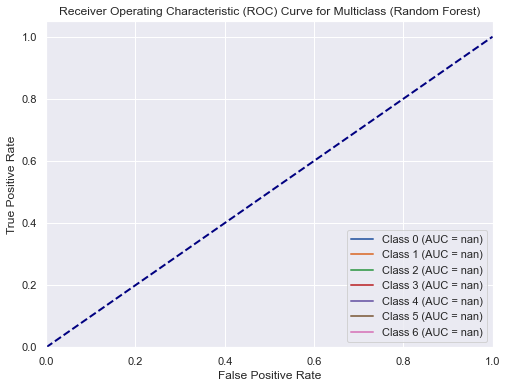

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you already have a trained Random Forest model (RanFor_model)

# Predict class probabilities for the test set
y_probabilities = RanFor_model.predict_proba(X_test)

# Initialize lists to store fpr, tpr, and auc values for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(len(RanFor_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(RanFor_model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass (Random Forest)')
plt.legend(loc='lower right')
plt.show()


[0.  0.1 0.2 1. ]
[nan nan nan nan]
[0.  0.1 0.8 1. ]
[nan nan nan nan]
[0.  0.1 0.8 1. ]
[nan nan nan nan]
[0.  0.1 0.8 1. ]
[nan nan nan nan]
[0.  0.1 0.3 1. ]
[nan nan nan nan]
[0.  0.1 1. ]
[nan nan nan]
[0.  0.1 1. ]
[nan nan nan]
0
nan
1
nan
2
nan
3
nan
4
nan
5
nan
6
nan


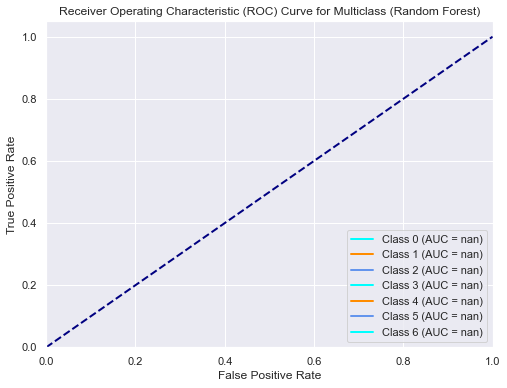

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier

# Assuming you have already trained your RandomForestClassifier model (RanFor_model)

# Predict class probabilities for the test set
y_probabilities = RanFor_model.predict_proba(X_test)

# Binarize the labels for multiclass ROC
n_classes = len(RanFor_model.classes_)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Initialize lists to store fpr, tpr, and auc values for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probabilities[:, i])
    print(fpr[i])
    print(tpr[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    print(i)
    plt.plot(fpr[i], tpr[i], lw=2, color=color, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(roc_auc[i])
# Customize the plot
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass (Random Forest)')
plt.legend(loc='lower right')
plt.show()


In [108]:
y_probabilities

array([[0.00000000e+00, 0.00000000e+00, 9.45901745e-02, 3.55555556e-02,
        0.00000000e+00, 3.02222222e-02, 8.39632048e-01],
       [0.00000000e+00, 1.94441991e-01, 1.89267211e-01, 9.16507937e-03,
        0.00000000e+00, 4.89946810e-01, 1.17178909e-01],
       [0.00000000e+00, 2.58741259e-03, 1.97079039e-01, 5.55555556e-04,
        0.00000000e+00, 9.53676722e-02, 7.04410320e-01],
       [0.00000000e+00, 4.13333333e-03, 2.10253302e-02, 3.20031990e-01,
        0.00000000e+00, 4.29353050e-01, 2.25456296e-01],
       [0.00000000e+00, 1.34731269e-02, 1.37642871e-01, 1.82818744e-02,
        0.00000000e+00, 6.60719574e-01, 1.69882554e-01],
       [0.00000000e+00, 8.41818182e-03, 1.01126221e-01, 1.78935961e-02,
        0.00000000e+00, 7.24837456e-01, 1.47724545e-01],
       [0.00000000e+00, 9.33540793e-02, 1.47311032e-01, 5.34269841e-02,
        3.33333333e-03, 3.71988525e-01, 3.30586046e-01],
       [1.25000000e-03, 0.00000000e+00, 0.00000000e+00, 9.54438228e-01,
        4.10714286e-03, 2

# Model Results Using Validation Set

## Accuracy Score

In [109]:
knn_accuracy_score = accuracy_score(y_test, knn_yhat)
tree1_accuracy_score = accuracy_score(y_test, tree_yhat)
tree2_accuracy_score = accuracy_score(y_test, tree_yhat2)
svm_accuracy_score = accuracy_score(y_test, SVM_yhat)
logreg_accuracy_score = accuracy_score(y_test, logreg_yhat)
ranfor_accuracy_score = accuracy_score(y_test, RanFor_yhat)

In [110]:
results = pd.DataFrame({
    'Model':['KNN',
             'Tree_1',
            'Tree_2',
            'SVM',
             'LogReg',
             'RanFor'
            ],
    
    'Score':[knn_accuracy_score,
             tree1_accuracy_score,
             tree2_accuracy_score,
             svm_accuracy_score,
             logreg_accuracy_score,
            ranfor_accuracy_score
            ]})

sorted_result = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result.round(3)

,Model,Score
0,RanFor,0.8
1,Tree_2,0.7
2,KNN,0.6
3,Tree_1,0.6
4,SVM,0.6
5,LogReg,0.6


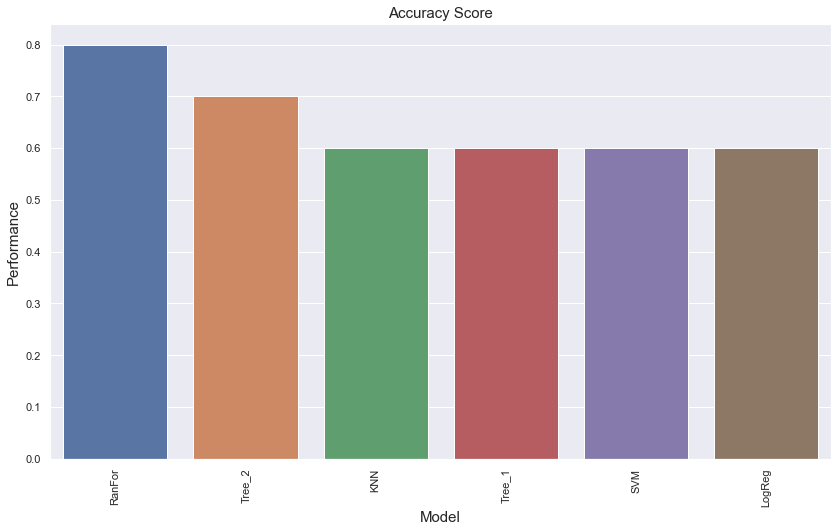

In [111]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result['Model'], y=sorted_result['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
#plt.ylim(0.10, 0.12)
plt.title('Accuracy Score', fontsize=15)
plt.show()

## Jaccard Score

In [112]:
knn_jaccard_score = jaccard_score(y_test, knn_yhat, average='macro')
tree1_jaccard_score = jaccard_score(y_test, tree_yhat, average='macro')
tree2_jaccard_score = jaccard_score(y_test, tree_yhat2, average='macro')
svm_jaccard_score = jaccard_score(y_test, SVM_yhat, average='macro')
logreg_jaccard_score = jaccard_score(y_test, logreg_yhat, average='macro')
ranfor_jaccard_score = jaccard_score(y_test, RanFor_yhat, average='macro')

In [113]:
results = pd.DataFrame({
    'Model':['KNN',
             'Tree_1',
            'Tree_2',
            'SVM',
             'LogReg',
             'RanFor'
            ],
    
    'Score':[knn_jaccard_score,
             tree1_jaccard_score,
             tree2_jaccard_score,
             svm_jaccard_score,
             logreg_jaccard_score,
            ranfor_jaccard_score
            ]})

sorted_result = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result.round(2)

,Model,Score
0,RanFor,0.71
1,Tree_1,0.42
2,Tree_2,0.42
3,KNN,0.36
4,SVM,0.35
5,LogReg,0.35


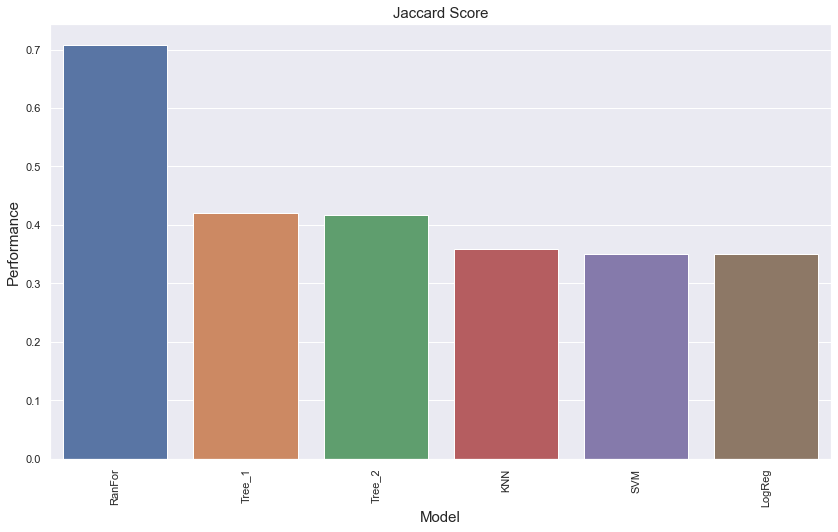

In [114]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result['Model'], y=sorted_result['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
#plt.ylim(0.10, 0.12)
plt.title('Jaccard Score', fontsize=15)
plt.show()

## F1 Score

In [115]:
knn_f1_score = f1_score(y_test, knn_yhat, average='macro')
tree1_f1_score = f1_score(y_test, tree_yhat, average='macro')
tree2_f1_score = f1_score(y_test, tree_yhat2, average='macro')
svm_f1_score = f1_score(y_test, SVM_yhat, average='macro')
logreg_f1_score = f1_score(y_test, logreg_yhat, average='macro')
ranfor_f1_score = f1_score(y_test, RanFor_yhat, average='macro')

In [116]:
results = pd.DataFrame({
    'Model':['KNN',
             'Tree_1',
            'Tree_2',
            'SVM',
             'LogReg',
             'RanFor'
            ],
    
    'Score':[knn_f1_score,
             tree1_f1_score,
             tree2_f1_score,
             svm_f1_score,
             logreg_f1_score,
            ranfor_f1_score
            ]})

sorted_result = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result.round(2)

,Model,Score
0,RanFor,0.82
1,Tree_1,0.58
2,Tree_2,0.53
3,KNN,0.48
4,SVM,0.48
5,LogReg,0.48


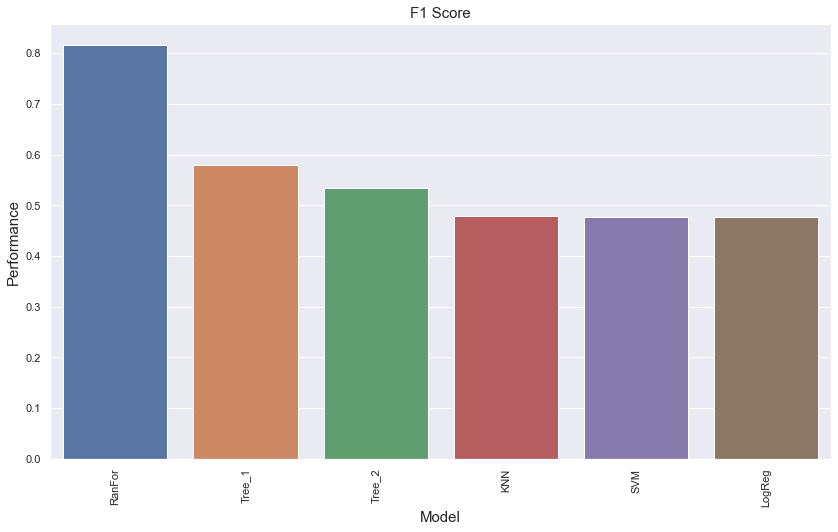

In [117]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result['Model'], y=sorted_result['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
#plt.ylim(0.10, 0.12)
plt.title('F1 Score', fontsize=15)
plt.show()

## Precision Score

In [118]:
knn_precision_score = precision_score(y_test, knn_yhat, average='macro')
tree1_precision_score = precision_score(y_test, tree_yhat, average='macro')
tree2_precision_score = precision_score(y_test, tree_yhat2, average='macro')
svm_precision_score = precision_score(y_test, SVM_yhat, average='macro')
logreg_precision_score = precision_score(y_test, logreg_yhat, average='macro')
ranfor_precision_score = precision_score(y_test, RanFor_yhat, average='macro')

In [119]:
results = pd.DataFrame({
    'Model':['KNN',
             'Tree_1',
            'Tree_2',
            'SVM',
             'LogReg',
             'RanFor'
            ],
    
    'Score':[knn_precision_score,
             tree1_precision_score,
             tree2_precision_score,
             svm_precision_score,
             logreg_precision_score,
            ranfor_precision_score
            ]})

sorted_result = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result.round(2)

,Model,Score
0,RanFor,0.82
1,Tree_1,0.69
2,KNN,0.50
3,Tree_2,0.49
4,SVM,0.44
5,LogReg,0.44


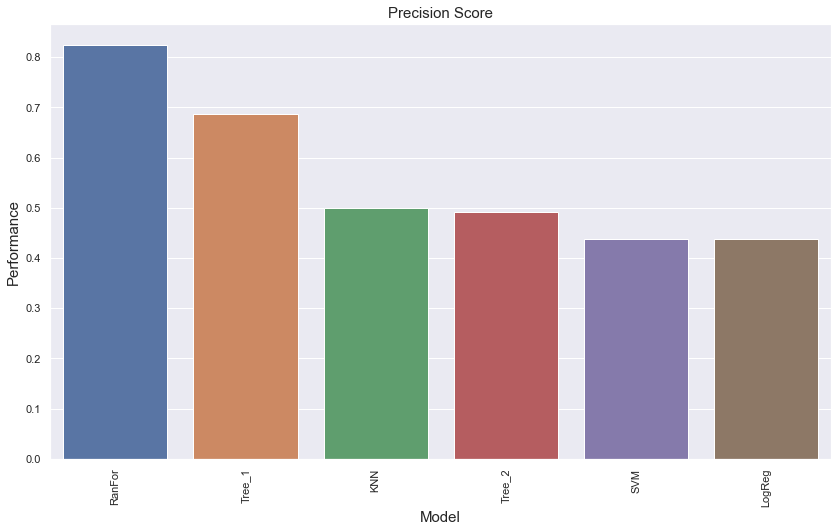

In [120]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result['Model'], y=sorted_result['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
#plt.ylim(0.10, 0.12)
plt.title('Precision Score', fontsize=15)
plt.show()

## Recall Score

In [121]:
knn_recall_score = round(recall_score(y_test, knn_yhat, average='macro'), 3)
tree1_recall_score = recall_score(y_test, tree_yhat, average='macro')
tree2_recall_score = recall_score(y_test, tree_yhat2, average='macro')
svm_recall_score = recall_score(y_test, SVM_yhat, average='macro')
logreg_recall_score = recall_score(y_test, logreg_yhat, average='macro')
ranfor_recall_score = recall_score(y_test, RanFor_yhat, average='macro')

In [122]:
results = pd.DataFrame({
    'Model':['KNN',
             'Tree_1',
            'Tree_2',
            'SVM',
             'LogReg',
             'RanFor'
            ],
    
    'Score':[knn_recall_score,
             tree1_recall_score,
             tree2_recall_score,
             svm_recall_score,
             logreg_recall_score,
            ranfor_recall_score
            ]})

sorted_result = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result.round(2)

,Model,Score
0,RanFor,0.87
1,Tree_1,0.73
2,Tree_2,0.62
3,KNN,0.57
4,SVM,0.57
5,LogReg,0.57


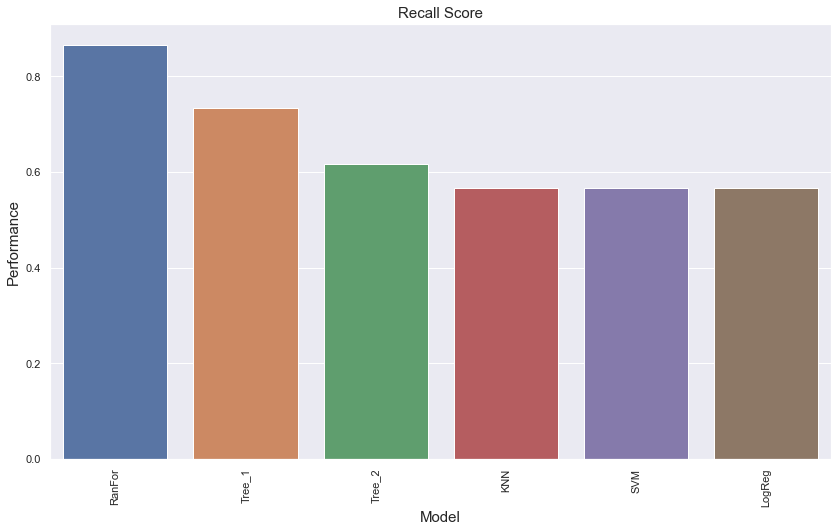

In [123]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result['Model'], y=sorted_result['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
#plt.ylim(0.10, 0.12)
plt.title('Recall Score', fontsize=15)
plt.show()

# Report

According to the above evaluation, the KNN model records the higher score among the tested models with different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


In [124]:
results = {
    'Accuracy':[knn_accuracy_score,
             tree1_accuracy_score,
             tree2_accuracy_score,
             svm_accuracy_score,
             logreg_accuracy_score,
            ranfor_accuracy_score],
            
    'Jaccard':[knn_jaccard_score,
             tree1_jaccard_score,
             tree2_jaccard_score,
             svm_jaccard_score,
             logreg_jaccard_score,
            ranfor_jaccard_score],
    
    'F1':[knn_f1_score,
             tree1_f1_score,
             tree2_f1_score,
             svm_f1_score,
             logreg_f1_score,
            ranfor_f1_score],
    
   'Precision':[knn_precision_score,
             tree1_precision_score,
             tree2_precision_score,
             svm_precision_score,
             logreg_precision_score,
            ranfor_precision_score],
    
    'Recall':[knn_recall_score,
             tree1_recall_score,
             tree2_recall_score,
             svm_recall_score,
             logreg_recall_score,
            ranfor_recall_score]
        }

In [125]:
results_df = pd.DataFrame.from_dict(results,
                          columns=['KNN', 'Tree_1', 'Tree_2', 'SVM', 'LogReg', 'RanFor'],
                          orient='index')

results_df.T.round(4).sort_values(by='Accuracy', ascending=False)

,Accuracy,Jaccard,F1,Precision,Recall
RanFor,0.8,0.7083,0.8167,0.8250,0.8667
Tree_2,0.7,0.4167,0.5333,0.4917,0.6167
KNN,0.6,0.3583,0.4792,0.5000,0.5670
Tree_1,0.6,0.4208,0.5792,0.6875,0.7333
SVM,0.6,0.3500,0.4762,0.4375,0.5667
LogReg,0.6,0.3500,0.4762,0.4375,0.5667


In [126]:
# Now we can sort the score values by ecah evaluation matrics.

In [127]:
results_df.T.round(2).sort_values(by='F1', ascending=False)

,Accuracy,Jaccard,F1,Precision,Recall
RanFor,0.8,0.71,0.82,0.82,0.87
Tree_1,0.6,0.42,0.58,0.69,0.73
Tree_2,0.7,0.42,0.53,0.49,0.62
KNN,0.6,0.36,0.48,0.50,0.57
SVM,0.6,0.35,0.48,0.44,0.57
LogReg,0.6,0.35,0.48,0.44,0.57


In [128]:
results_df.T.round(2).sort_values(by='Recall', ascending=False)

,Accuracy,Jaccard,F1,Precision,Recall
RanFor,0.8,0.71,0.82,0.82,0.87
Tree_1,0.6,0.42,0.58,0.69,0.73
Tree_2,0.7,0.42,0.53,0.49,0.62
KNN,0.6,0.36,0.48,0.50,0.57
SVM,0.6,0.35,0.48,0.44,0.57
LogReg,0.6,0.35,0.48,0.44,0.57


## Saving the Model

In [140]:
import joblib

In [142]:
Profile_Patterns_RanFor = {
    'model': RanFor_model
                        }

In [143]:
joblib.dump(Profile_Patterns_RanFor, '4_final_Profile_Patterns_RanFor.joblib')

['4_final_Profile_Patterns_RanFor.joblib']

In [145]:
# Load the saved model from the .joblib file
loaded_model = joblib.load(r'C:\Users\r04ra18\Desktop\fault-dataset\final-notebooks\6-machine-learning-prediction\4_final_Profile_Patterns_RanFor.joblib')

In [146]:
loaded_model

{'model': RandomForestClassifier(max_depth=5, n_estimators=50, n_jobs=-1, random_state=42)}

In [147]:
test_disp_length = {'Length': 710, 'Displacement': 2.9}

In [148]:
test_disp_length

{'Length': 710, 'Displacement': 2.9}

In [149]:
test_df = pd.DataFrame([test_disp_length])

In [150]:
test_df.values

array([[710. ,   2.9]])

In [151]:
# preprocessing.StandardScaler().fit(test_df.values).transform(test_df.values)

In [152]:
loaded_model['model'].predict(test_df.values)

array(['Trapezoid'], dtype=object)

##### By: Ramy Abdallah
PhD candidate working on Reducing uncertainty of subsurface interpretation in fold-thrust models from outcrops to machine learning.

***Thank You***